In [1]:
import json
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import re
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [11]:
def extract_choice(text, reversed_mode=False):
    text = str(text)
    idx1 = text.find("Option 1")
    idx2 = text.find("Option 2")

    if idx1 == -1 and idx2 == -1:
        choice = "unknown"
    elif idx1 != -1 and idx2 != -1:
        choice = "1" if idx1 < idx2 else "2"
    elif idx1 != -1:
        choice = "1"
    else:
        choice = "2"
    
    if reversed_mode:
        choice = "2" if choice == "1" else "1"
    
    return choice

def load_model_data(model_name):
    original_path = f"/home/chewon1227/careerpathway/data/final_perma/{model_name}.jsonl"
    reverse_path = f"/home/chewon1227/careerpathway/data/final_perma/{model_name}-re.jsonl"
    
    df = pd.read_json(path_or_buf=original_path, lines=True)
    reversed_df = pd.read_json(path_or_buf=reverse_path, lines=True)
    
    # 7b만 사용 (7b-re 제외)
    df['llm_choice'] = df['llm_response'].apply(lambda x: extract_choice(x, reversed_mode=False))
    reversed_df['llm_choice'] = reversed_df['llm_response'].apply(lambda x: extract_choice(x, reversed_mode=True))
    
    # unknown을 NaN으로 변환
    df['llm_choice'] = df['llm_choice'].replace('unknown', np.nan)
    reversed_df['llm_choice'] = reversed_df['llm_choice'].replace('unknown', np.nan)
    
    # 숫자로 변환
    df['llm_choice'] = pd.to_numeric(df['llm_choice'], errors='coerce')
    reversed_df['llm_choice'] = pd.to_numeric(reversed_df['llm_choice'], errors='coerce')

    combined_df = pd.concat([df, reversed_df], ignore_index=True)
    
    return df, reversed_df, combined_df

def extract_numbers_from_description(description):
    if not description or pd.isna(description):
        return None
    
    try:
        # 숫자만 추출
        numbers = re.findall(r'\d+', str(description))
        if numbers:
            return int(numbers[0])  # 첫 번째 숫자 반환
        return None
    except Exception as e:
        print(f"Error extracting number from '{description}': {e}")
        return None

In [ ]:
def calculate_factor_wins(df, question_type):
    """
    특정 question_type에 대해 factor 간의 승수를 계산합니다.
    
    Args:
        df: 모델 데이터가 포함된 DataFrame
        question_type: 'word', 'factor', 'reddit-positive', 'reddit-negative' 중 하나
    
    Returns:
        win_matrix: 5x5 승수 행렬
        total_wins: 각 factor의 총 승수
    """
    # question_type에 해당하는 데이터만 필터링
    filtered_df = df[df['question_id'] == question_type].copy()
    
    # PERMA factors
    factors = ['P', 'E', 'R', 'M', 'A']
    
    # 승수 행렬 초기화 (5x5)
    win_matrix = pd.DataFrame(0, index=factors, columns=factors)
    
    # 각 factor 쌍에 대해 승수 계산
    for i, factor1 in enumerate(factors):
        for j, factor2 in enumerate(factors):
            if i != j:  # 자기 자신과는 비교하지 않음
                # factor1 vs factor2 비교 데이터 찾기
                mask = (filtered_df['factor1'] == factor1) & (filtered_df['factor2'] == factor2)
                comparison_data = filtered_df[mask]
                
                if len(comparison_data) > 0:
                    # Option 1이 이겼으면 factor1 승, Option 2가 이겼으면 factor2 승
                    wins_for_factor1 = (comparison_data['llm_choice'] == 1).sum()
                    wins_for_factor2 = (comparison_data['llm_choice'] == 2).sum()
                    
                    # 승수 행렬에 기록
                    win_matrix.loc[factor1, factor2] = wins_for_factor1
                    win_matrix.loc[factor2, factor1] = wins_for_factor2
    
    # 각 factor의 총 승수 계산
    total_wins = {}
    for factor in factors:
        total_wins[factor] = win_matrix.loc[factor].sum()
    
    return win_matrix, total_wins

def create_perma_visualization(model_name, question_type):
    df = load_model_data(model_name)
    
    # 승수 계산
    win_matrix, total_wins = calculate_factor_wins(df, question_type)
    
    # 시각화 생성 - 하나의 subplot만 사용
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # 1. 가로 막대 그래프 (Total Wins)
    factors = ['M', 'R', 'P', 'E', 'A']  # 이미지 순서대로
    colors = ['green', 'yellow', 'red', 'orange', 'blue']  # 이미지 색상대로
    
    # total_wins를 factors 순서대로 정렬
    wins_data = [total_wins[factor] for factor in factors]
    
    bars = ax.barh(factors, wins_data, color=colors)
    ax.set_xlim(0, 50)
    ax.set_xlabel('Total Wins')
    ax.set_ylabel('PERMA Factors')
    ax.set_title(f'{model_name.upper()} - {question_type.upper()}')
    
    # 막대 위에 값 표시
    for bar, win in zip(bars, wins_data):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{win}', va='center', fontweight='bold')
    
    # 2. Win Matrix 표를 막대 그래프 우하단에 배치
    # 표 위치 계산 (우하단)
    table_x = 0.65  # x 위치 (0~1, 오른쪽으로 갈수록 커짐)
    table_y = 0.15  # y 위치 (0~1, 아래쪽으로 갈수록 작아짐)
    table_width = 0.3  # 표 너비
    table_height = 0.4  # 표 높이
    
    # 표 데이터 준비 (이미지 순서대로)
    table_data = []
    for factor1 in factors:
        row = []
        for factor2 in factors:
            if factor1 == factor2:
                row.append('-')
            else:
                row.append(str(win_matrix.loc[factor1, factor2]))
        table_data.append(row)
    
    # 표를 막대 그래프 위에 겹치기
    table = ax.table(cellText=table_data, 
                     rowLabels=factors,
                     colLabels=factors,
                     cellLoc='center',
                     loc='upper right',
                     bbox=[table_x, table_y, table_width, table_height])
    
    # 표 스타일링
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    # 표 제목 추가
    ax.text(table_x + table_width/2, table_y + table_height + 0.02, 
            'Win Matrix', fontsize=12, fontweight='bold', 
            ha='center', transform=ax.transAxes)
    
    plt.tight_layout()
    return fig

def analyze_all_models(question_type):
    """
    모든 모델에 대해 특정 question_type의 분석을 수행합니다.
    
    Args:
        question_type: 'word', 'factor', 'reddit-positive', 'reddit-negative' 중 하나
    """
    models = ['7b', '14b', '32b']
    
    for model in models:
        print(f"\n=== {model.upper()} - {question_type.upper()} 분석 ===")
        
        # 데이터 로드
        df = load_model_data(model)
        
        # 승수 계산
        win_matrix, total_wins = calculate_factor_wins(df, question_type)
        
        print("\nWin Matrix:")
        print(win_matrix)
        
        print("\nTotal Wins:")
        for factor, wins in total_wins.items():
            print(f"{factor}: {wins}")
        
        # 시각화 생성
        fig = create_perma_visualization(model, question_type)
        plt.show()

def create_combined_visualization(question_type):
    """
    모든 모델을 하나의 그림에 표시하는 통합 시각화를 생성합니다.
    
    Args:
        question_type: 'word', 'factor', 'reddit-positive', 'reddit-negative' 중 하나
    """
    models = ['7b', '14b', '32b']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 20))
    
    for i, model in enumerate(models):
        # 데이터 로드
        df = load_model_data(model)
        win_matrix, total_wins = calculate_factor_wins(df, question_type)
        
        # 가로 막대 그래프
        factors = ['M', 'R', 'P', 'E', 'A']
        colors = ['green', 'yellow', 'red', 'orange', 'blue']
        wins_data = [total_wins[factor] for factor in factors]
        
        bars = axes[i].barh(factors, wins_data, color=colors)
        axes[i].set_xlim(0, 50)
        axes[i].set_xlabel('Total Wins')
        axes[i].set_ylabel('PERMA Factors')
        axes[i].set_title(f'{model.upper()} - {question_type.upper()}')
        
        # 막대 위에 값 표시
        for bar, win in zip(bars, wins_data):
            axes[i].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                       f'{win}', va='center', fontweight='bold')
        
        # Win Matrix 표를 막대 그래프 우하단에 배치
        # 표 위치 계산 (우하단)
        table_x = 0.65  # x 위치 (0~1, 오른쪽으로 갈수록 커짐)
        table_y = 0.15  # y 위치 (0~1, 아래쪽으로 갈수록 작아짐)
        table_width = 0.3  # 표 너비
        table_height = 0.4  # 표 높이
        
        table_data = []
        for factor1 in factors:
            row = []
            for factor2 in factors:
                if factor1 == factor2:
                    row.append('-')
                else:
                    row.append(str(win_matrix.loc[factor1, factor2]))
            table_data.append(row)
        
        # 표를 막대 그래프 위에 겹치기
        table = axes[i].table(cellText=table_data, 
                            rowLabels=factors,
                            colLabels=factors,
                            cellLoc='center',
                            loc='upper right',
                            bbox=[table_x, table_y, table_width, table_height])
        
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 1.2)
        
        # 표 제목 추가
        axes[i].text(table_x + table_width/2, table_y + table_height + 0.02, 
                    'Win Matrix', fontsize=10, fontweight='bold', 
                    ha='center', transform=axes[i].transAxes)
    
    plt.tight_layout()
    return fig

# 사용 예시
if __name__ == "__main__":
    # 특정 question_type 분석
    print("=== WORD 데이터 분석 ===")
    analyze_all_models('word')
    
    # 통합 시각화 생성
    print("\n=== 통합 시각화 생성 ===")
    combined_fig = create_combined_visualization('word')
    plt.show()



=== Processing 7b ===
PERMA combinations: [('P', 'E'), ('P', 'R'), ('P', 'M'), ('P', 'A'), ('E', 'R'), ('E', 'M'), ('E', 'A'), ('R', 'M'), ('R', 'A'), ('M', 'A')]
P vs E: 270 rows
  Factor1 (P) range: (2, 7)
  Factor2 (E) range: (2, 10)
  P: 265, E: 5
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
P vs R: 270 rows
  Factor1 (P) range: (2, 7)
  Factor2 (R) range: (2, 10)
  P: 52, R: 218
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
P vs M: 180 rows
  Factor1 (P) range: (2, 7)
  Factor2 (M) range: (2, 7)
  P: 127, M: 53
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
P vs A: 270 rows
  Factor1 (P) range: (2, 7)
  Factor2 (A) range: (2, 10)
  P: 244, A: 26
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
E vs R: 405 rows
  Factor1 (E) range: (2, 10)
  Factor2 (R) range: (2, 10)
  E: 152, R: 253
  Keywords found: ['well-being', 'balanced

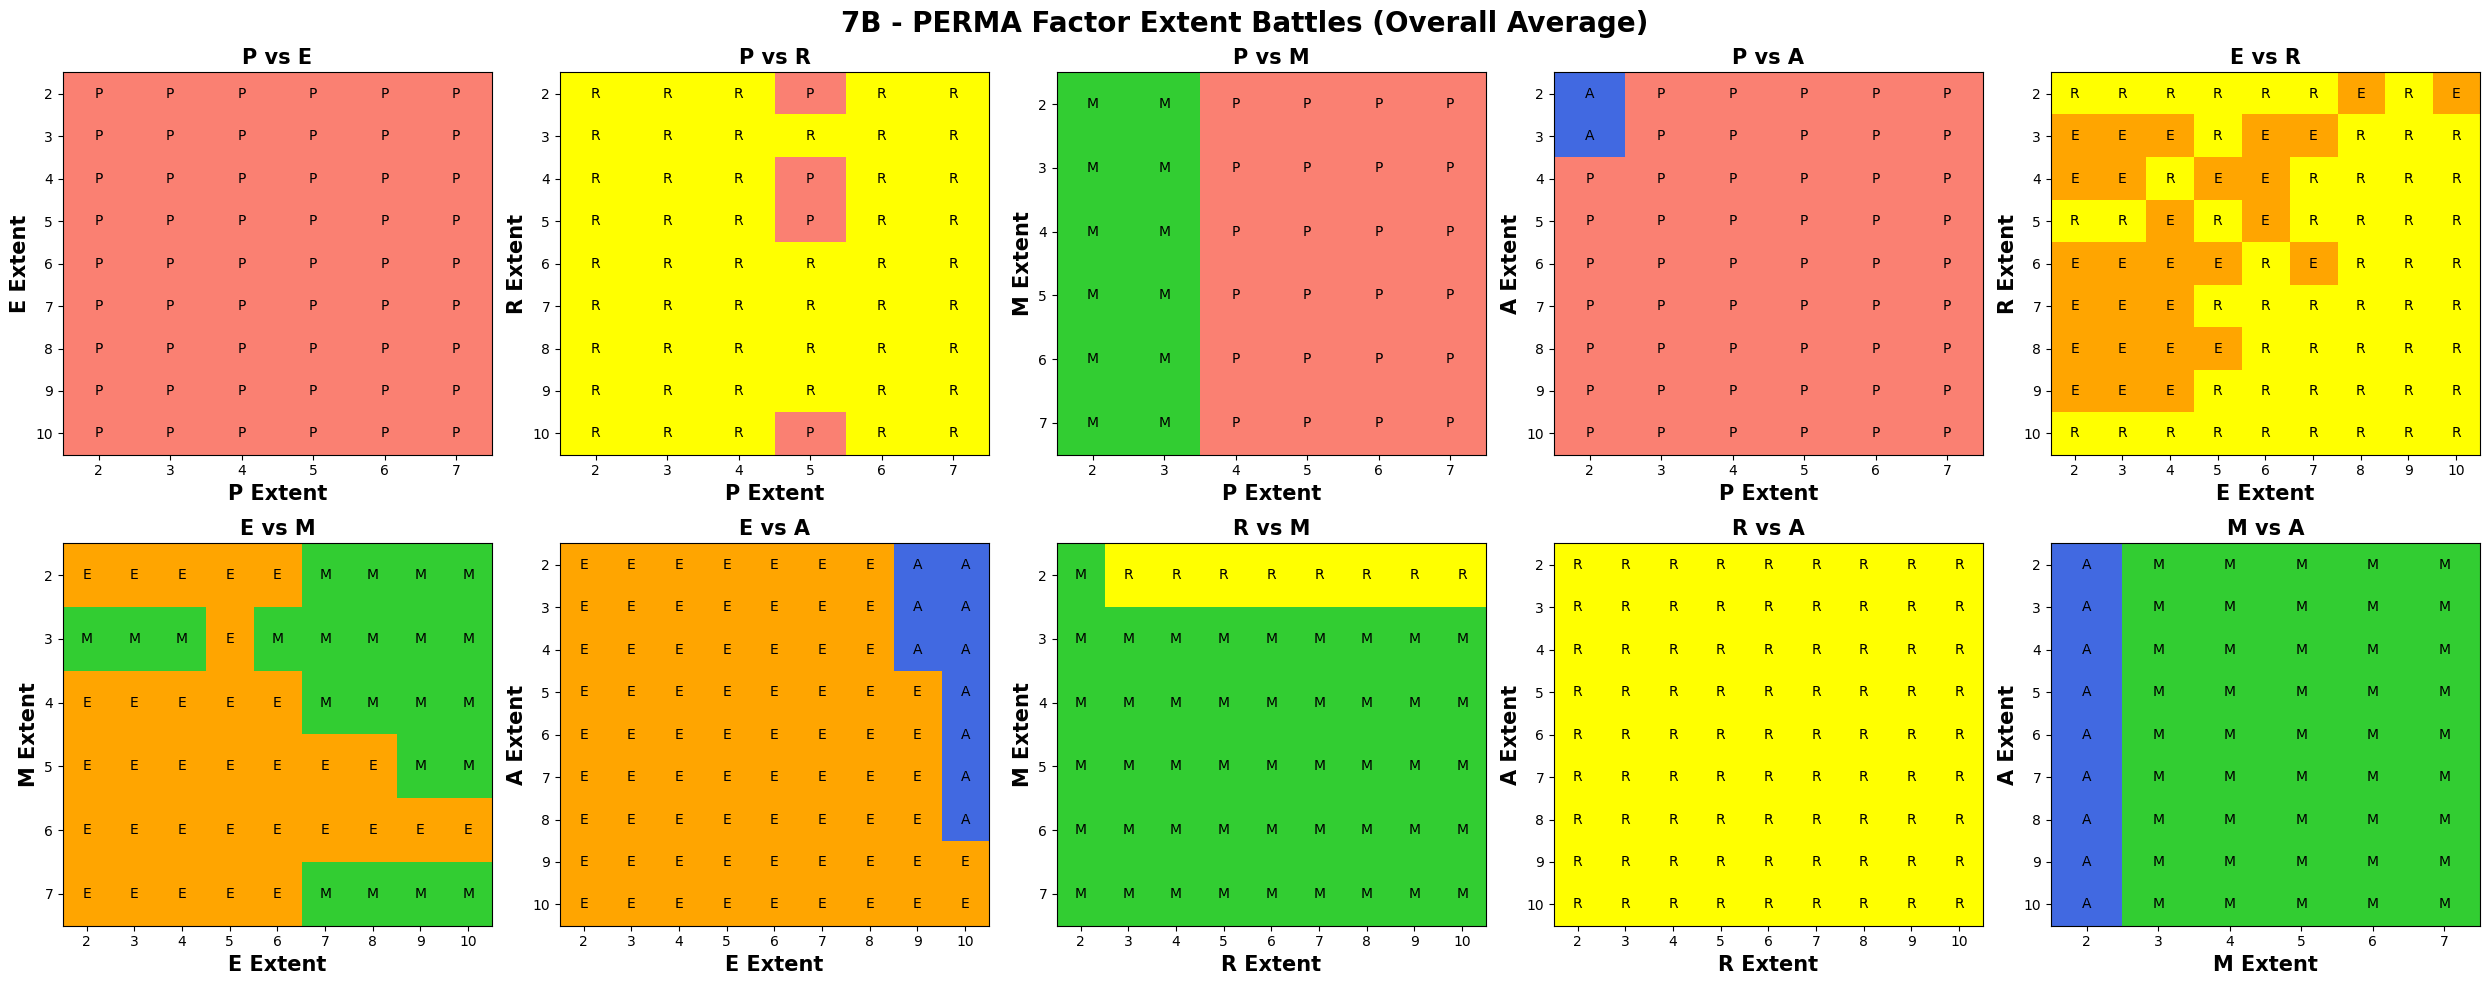

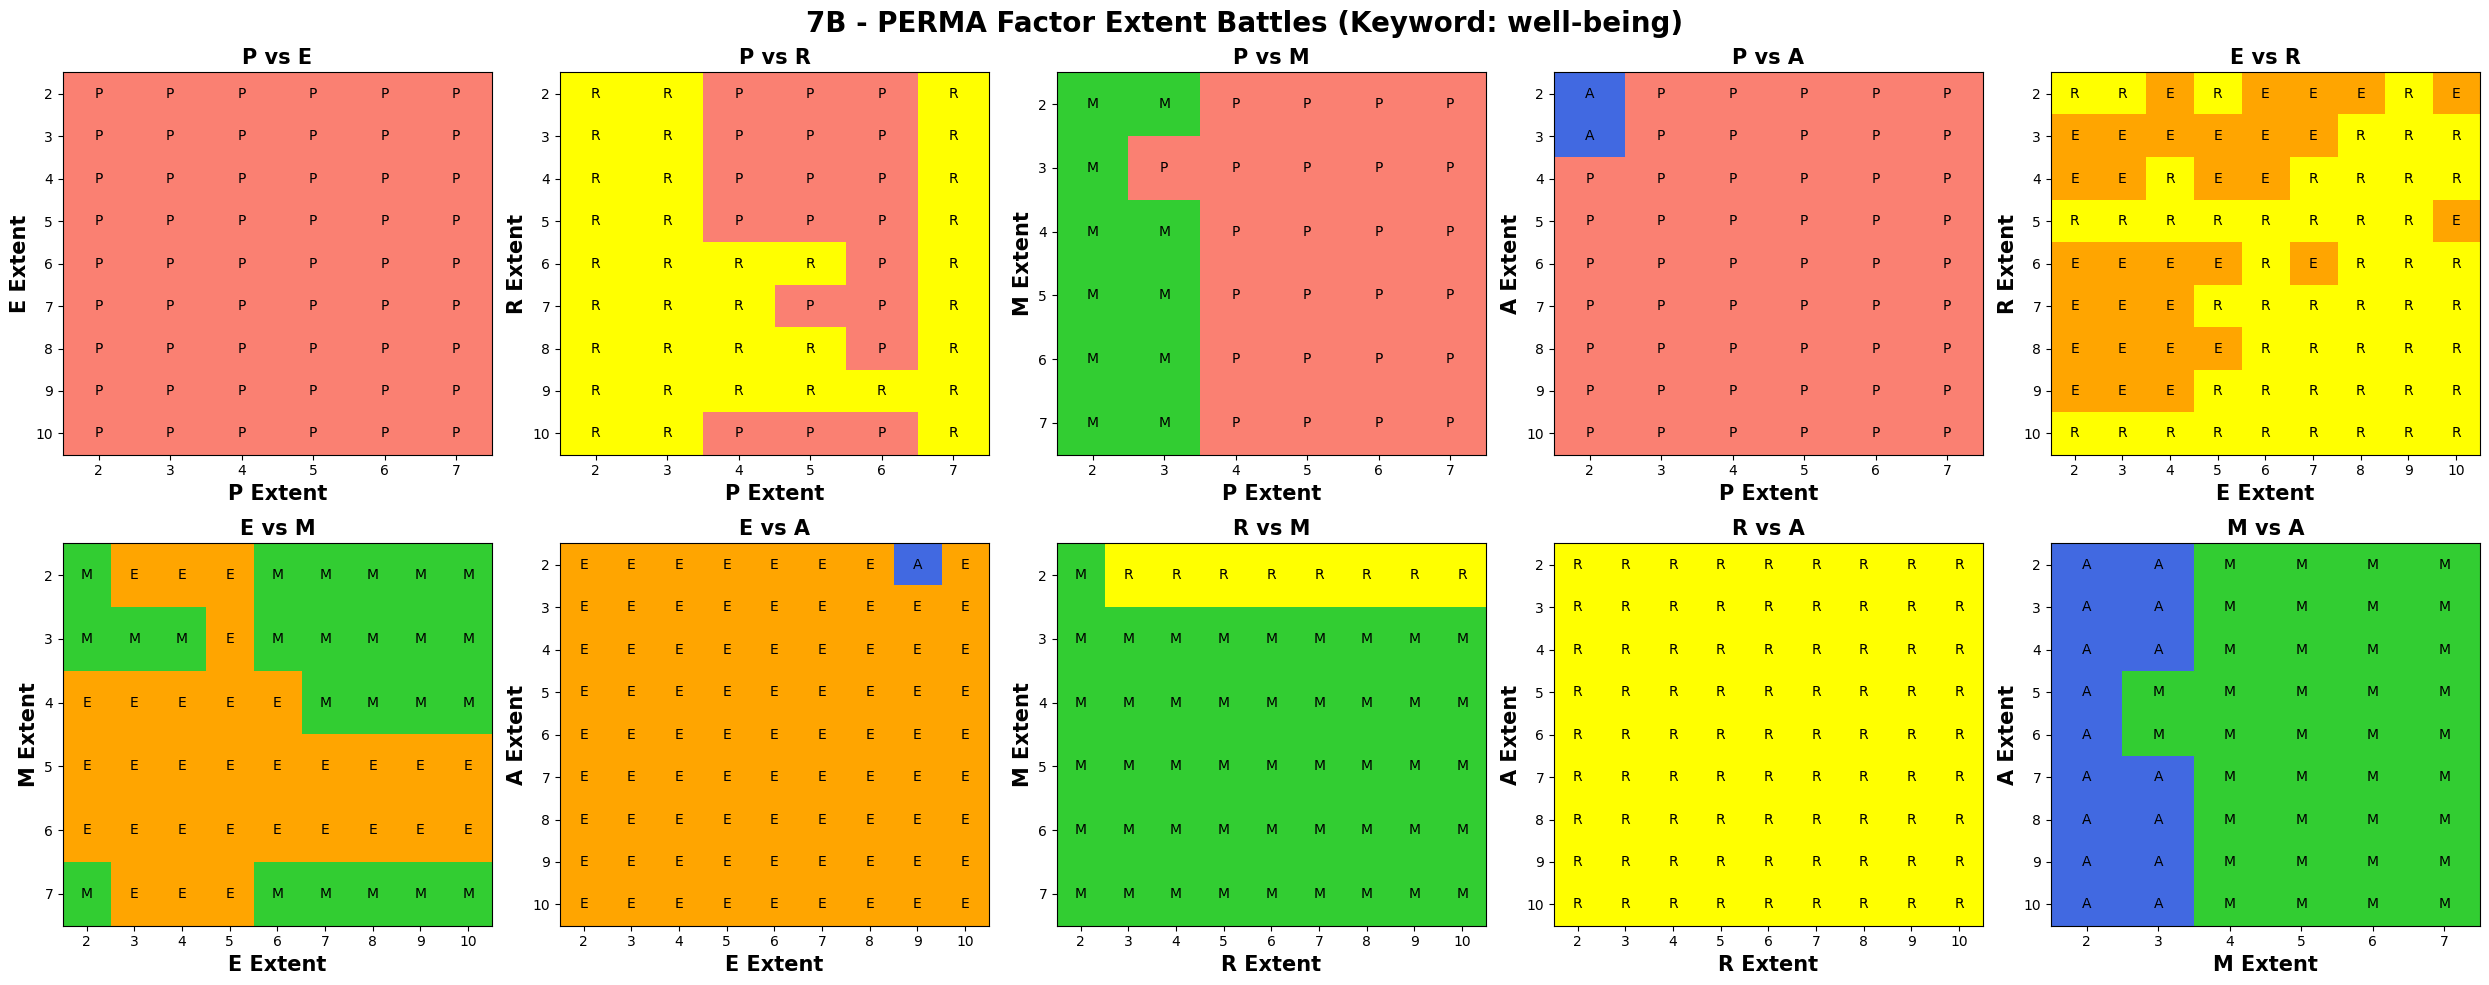

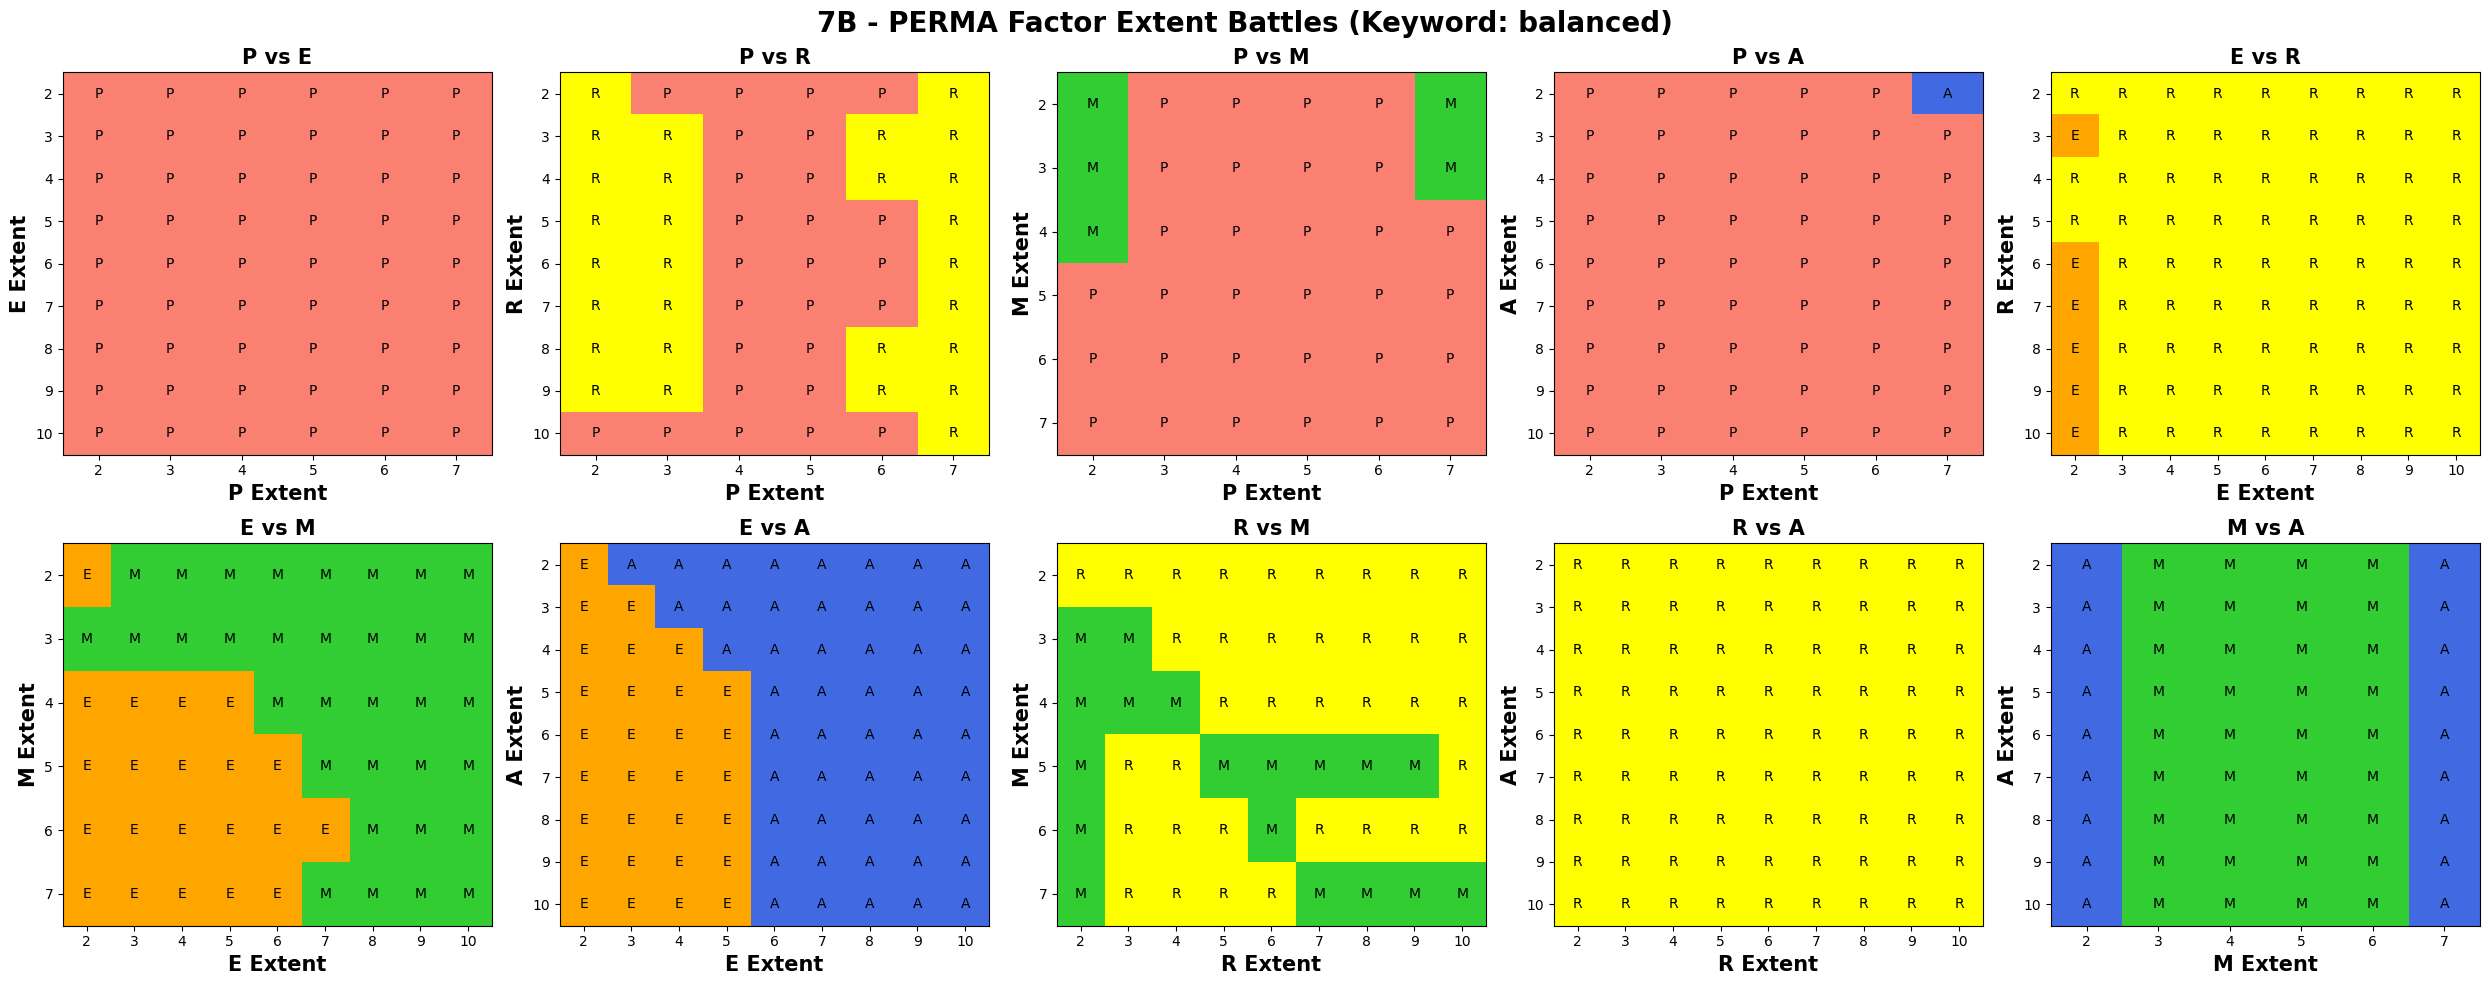

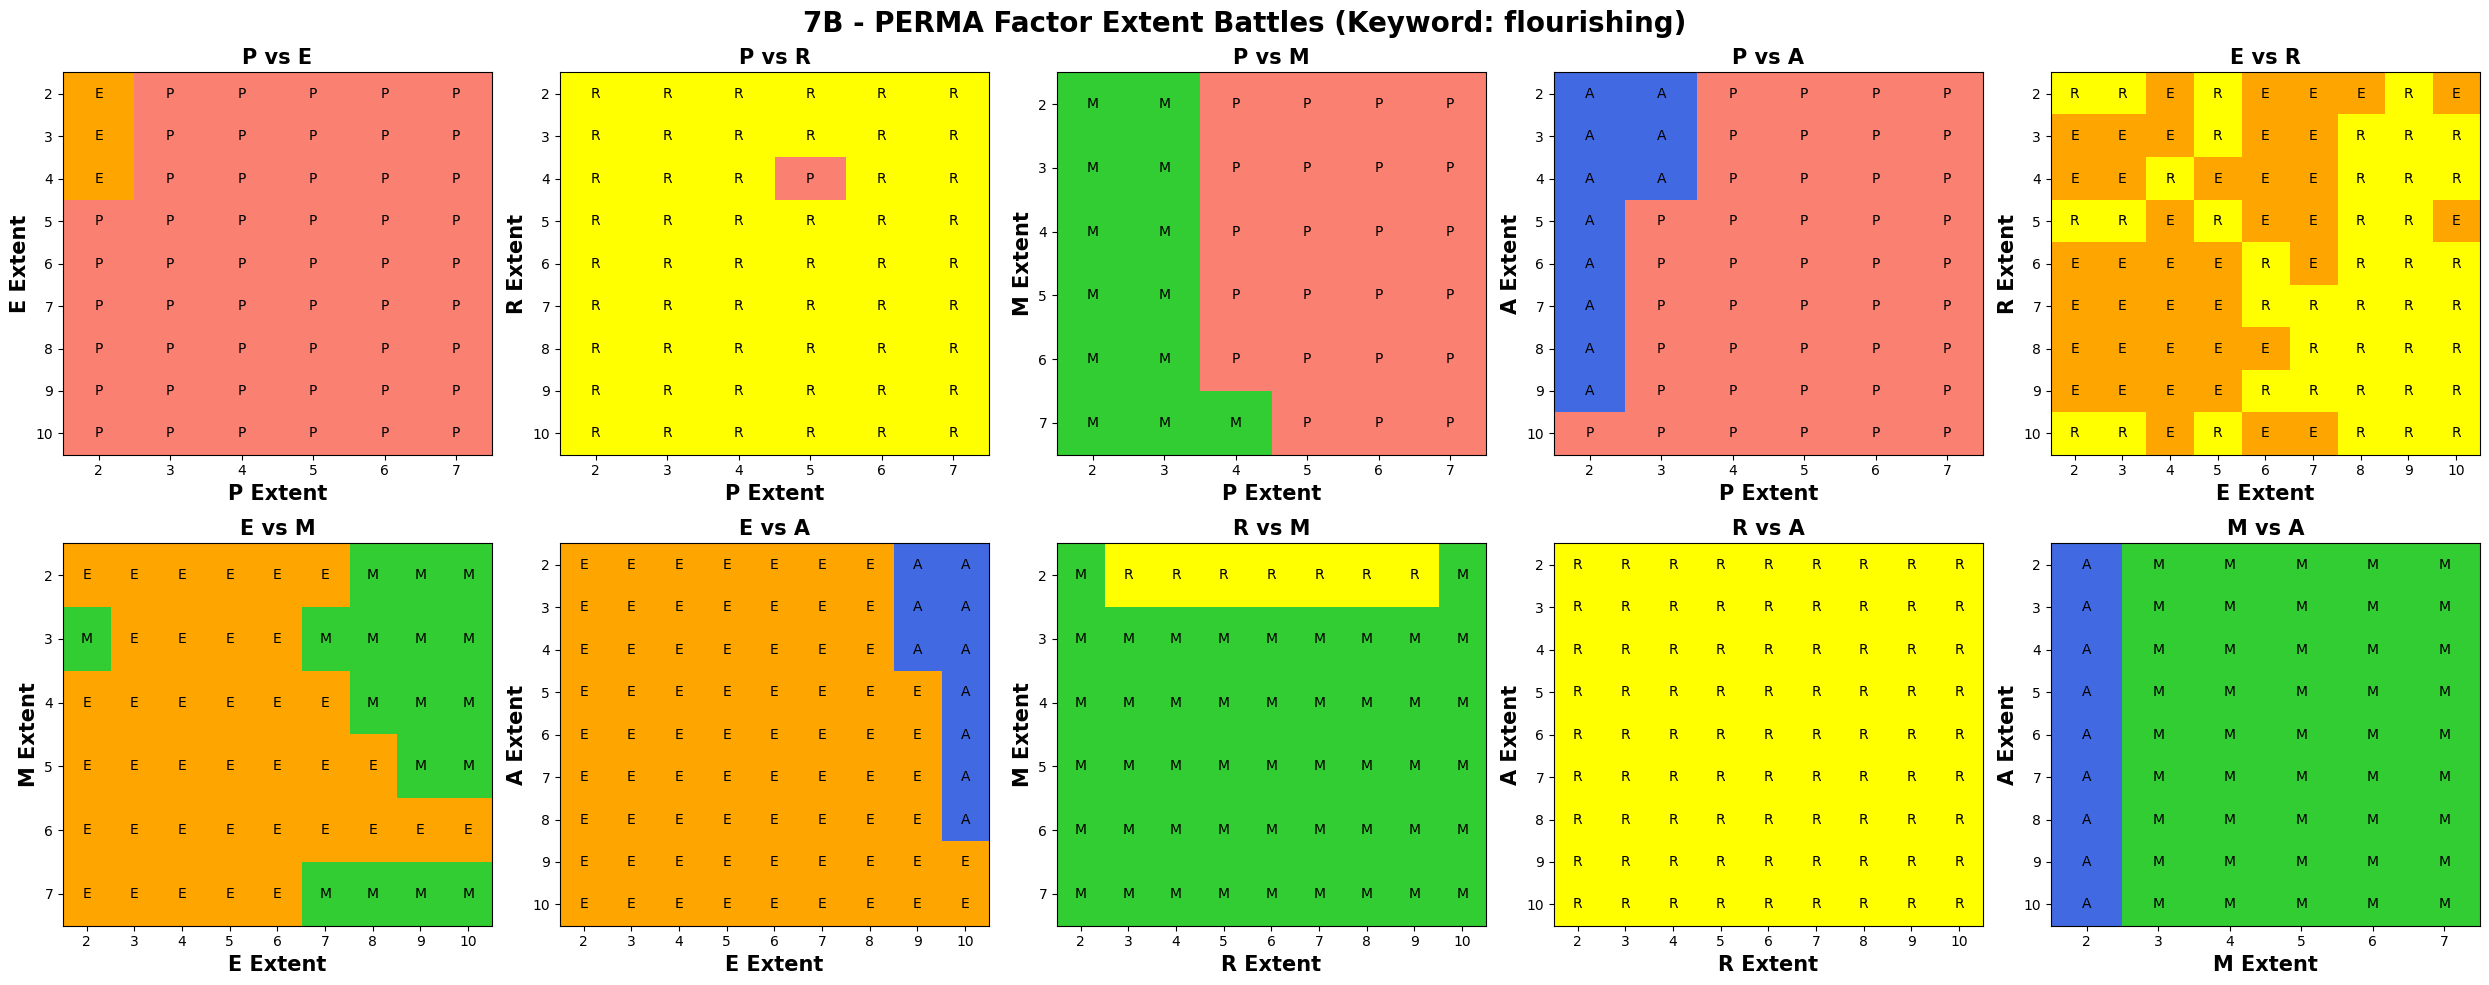

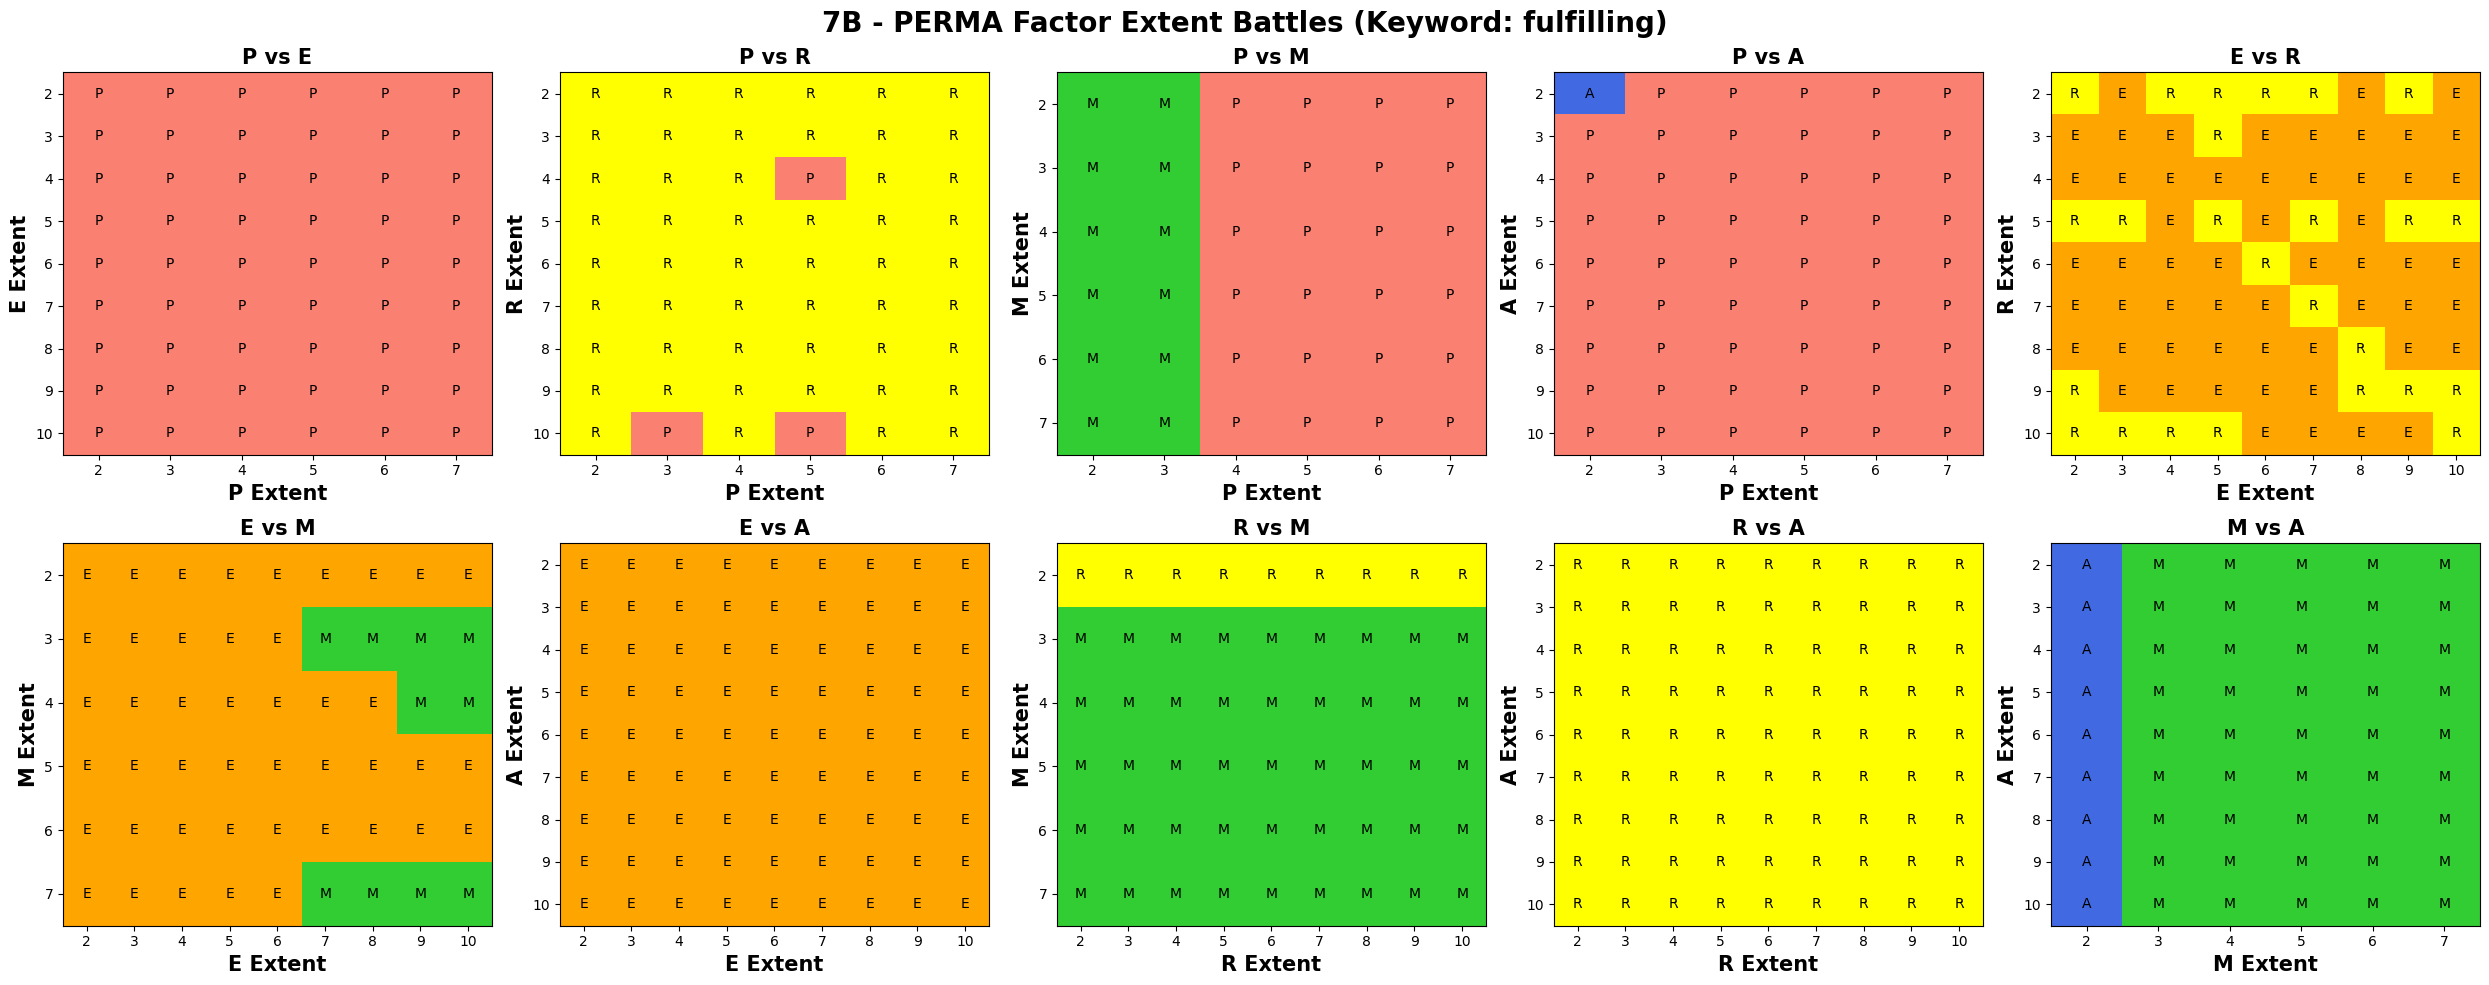

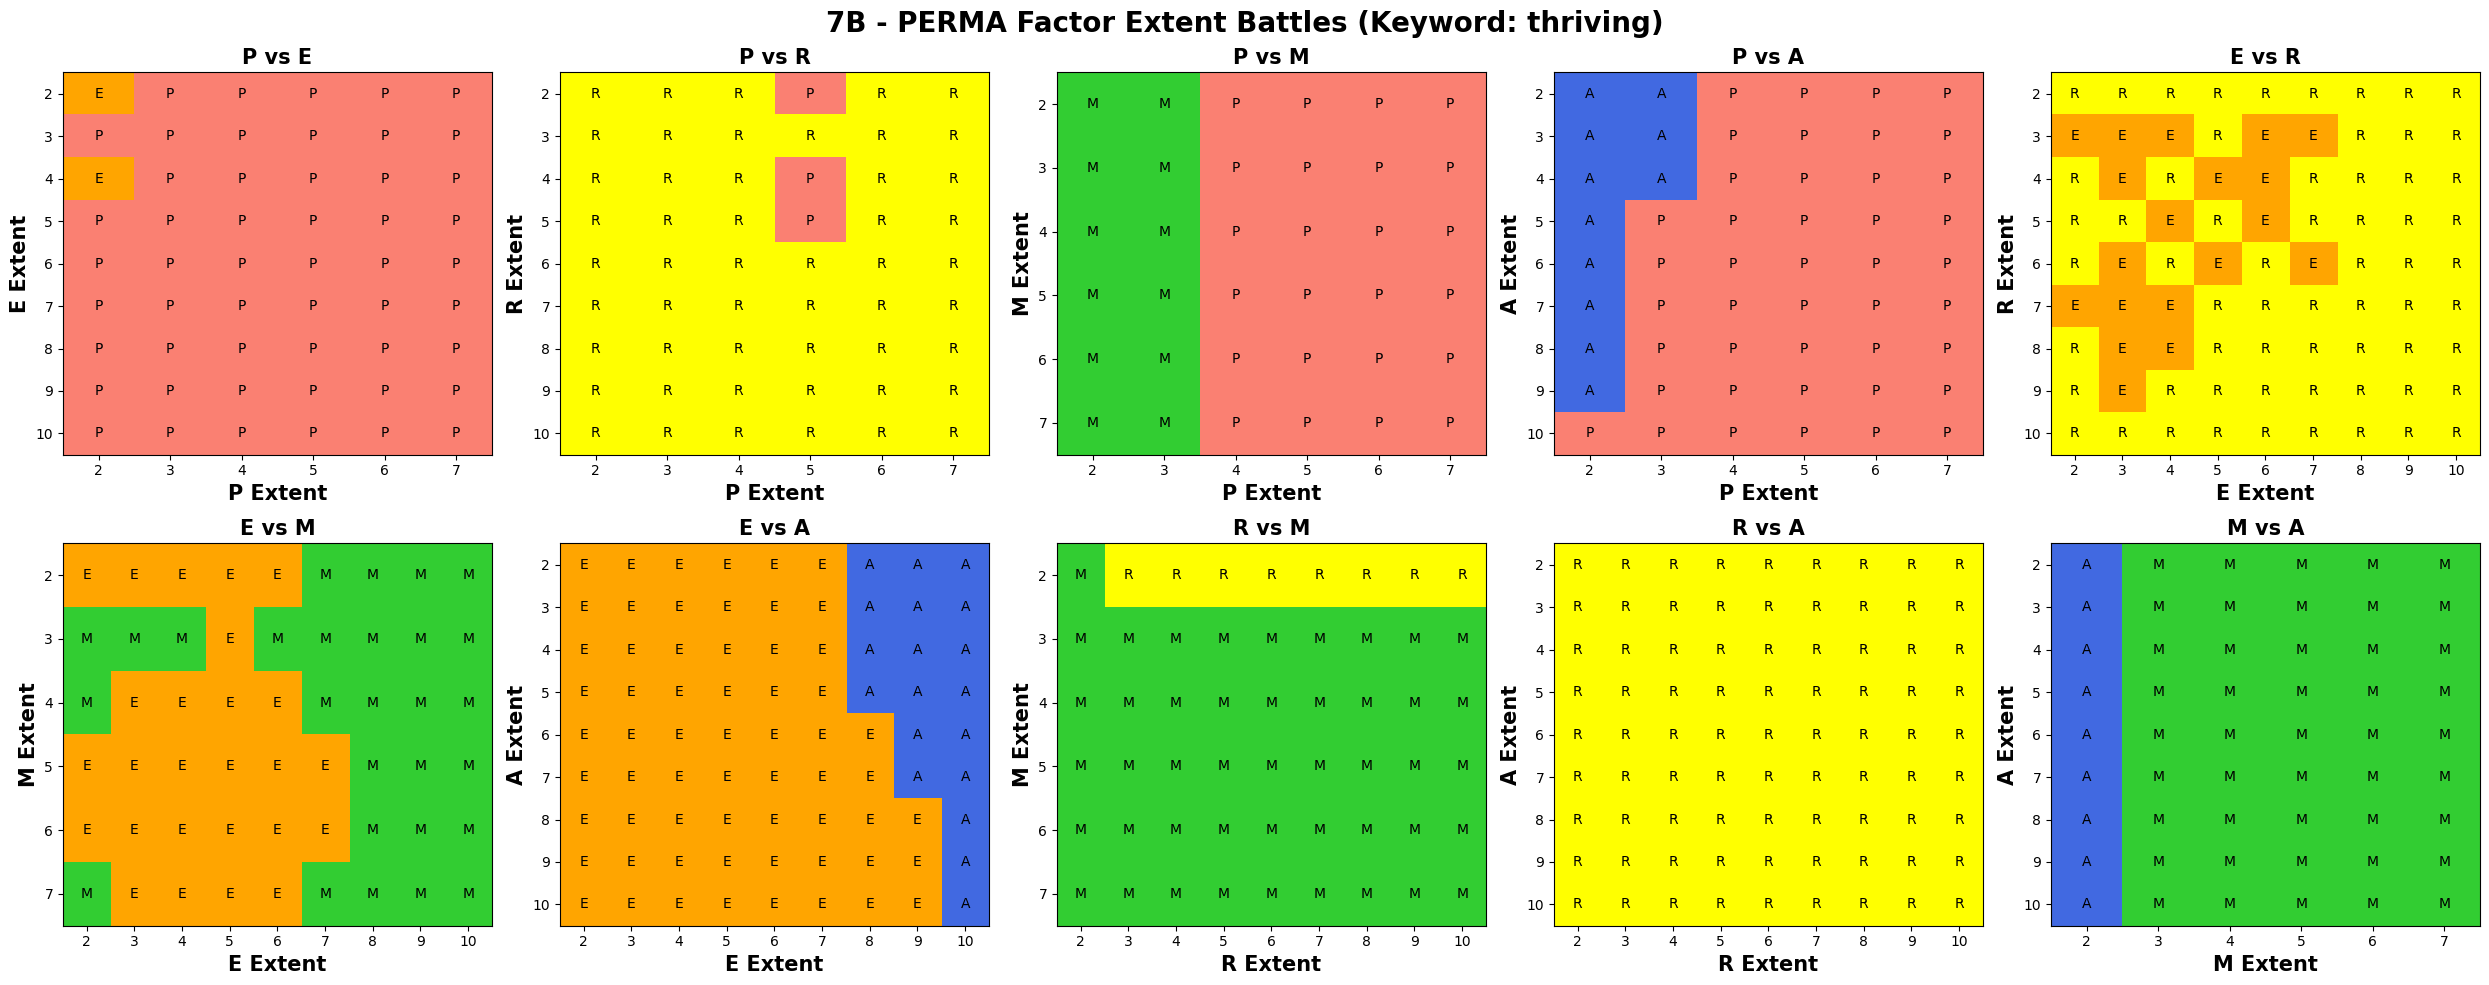


Analysis complete!

=== Processing 14b ===
PERMA combinations: [('P', 'E'), ('P', 'R'), ('P', 'M'), ('P', 'A'), ('E', 'R'), ('E', 'M'), ('E', 'A'), ('R', 'M'), ('R', 'A'), ('M', 'A')]
P vs E: 270 rows
  Factor1 (P) range: (2, 7)
  Factor2 (E) range: (2, 10)
  P: 270, E: 0
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
P vs R: 270 rows
  Factor1 (P) range: (2, 7)
  Factor2 (R) range: (2, 10)
  P: 269, R: 1
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
P vs M: 180 rows
  Factor1 (P) range: (2, 7)
  Factor2 (M) range: (2, 7)
  P: 177, M: 3
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
P vs A: 270 rows
  Factor1 (P) range: (2, 7)
  Factor2 (A) range: (2, 10)
  P: 270, A: 0
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
E vs R: 405 rows
  Factor1 (E) range: (2, 10)
  Factor2 (R) range: (2, 10)
  E: 21, R: 384
  Keywords found: ['well-

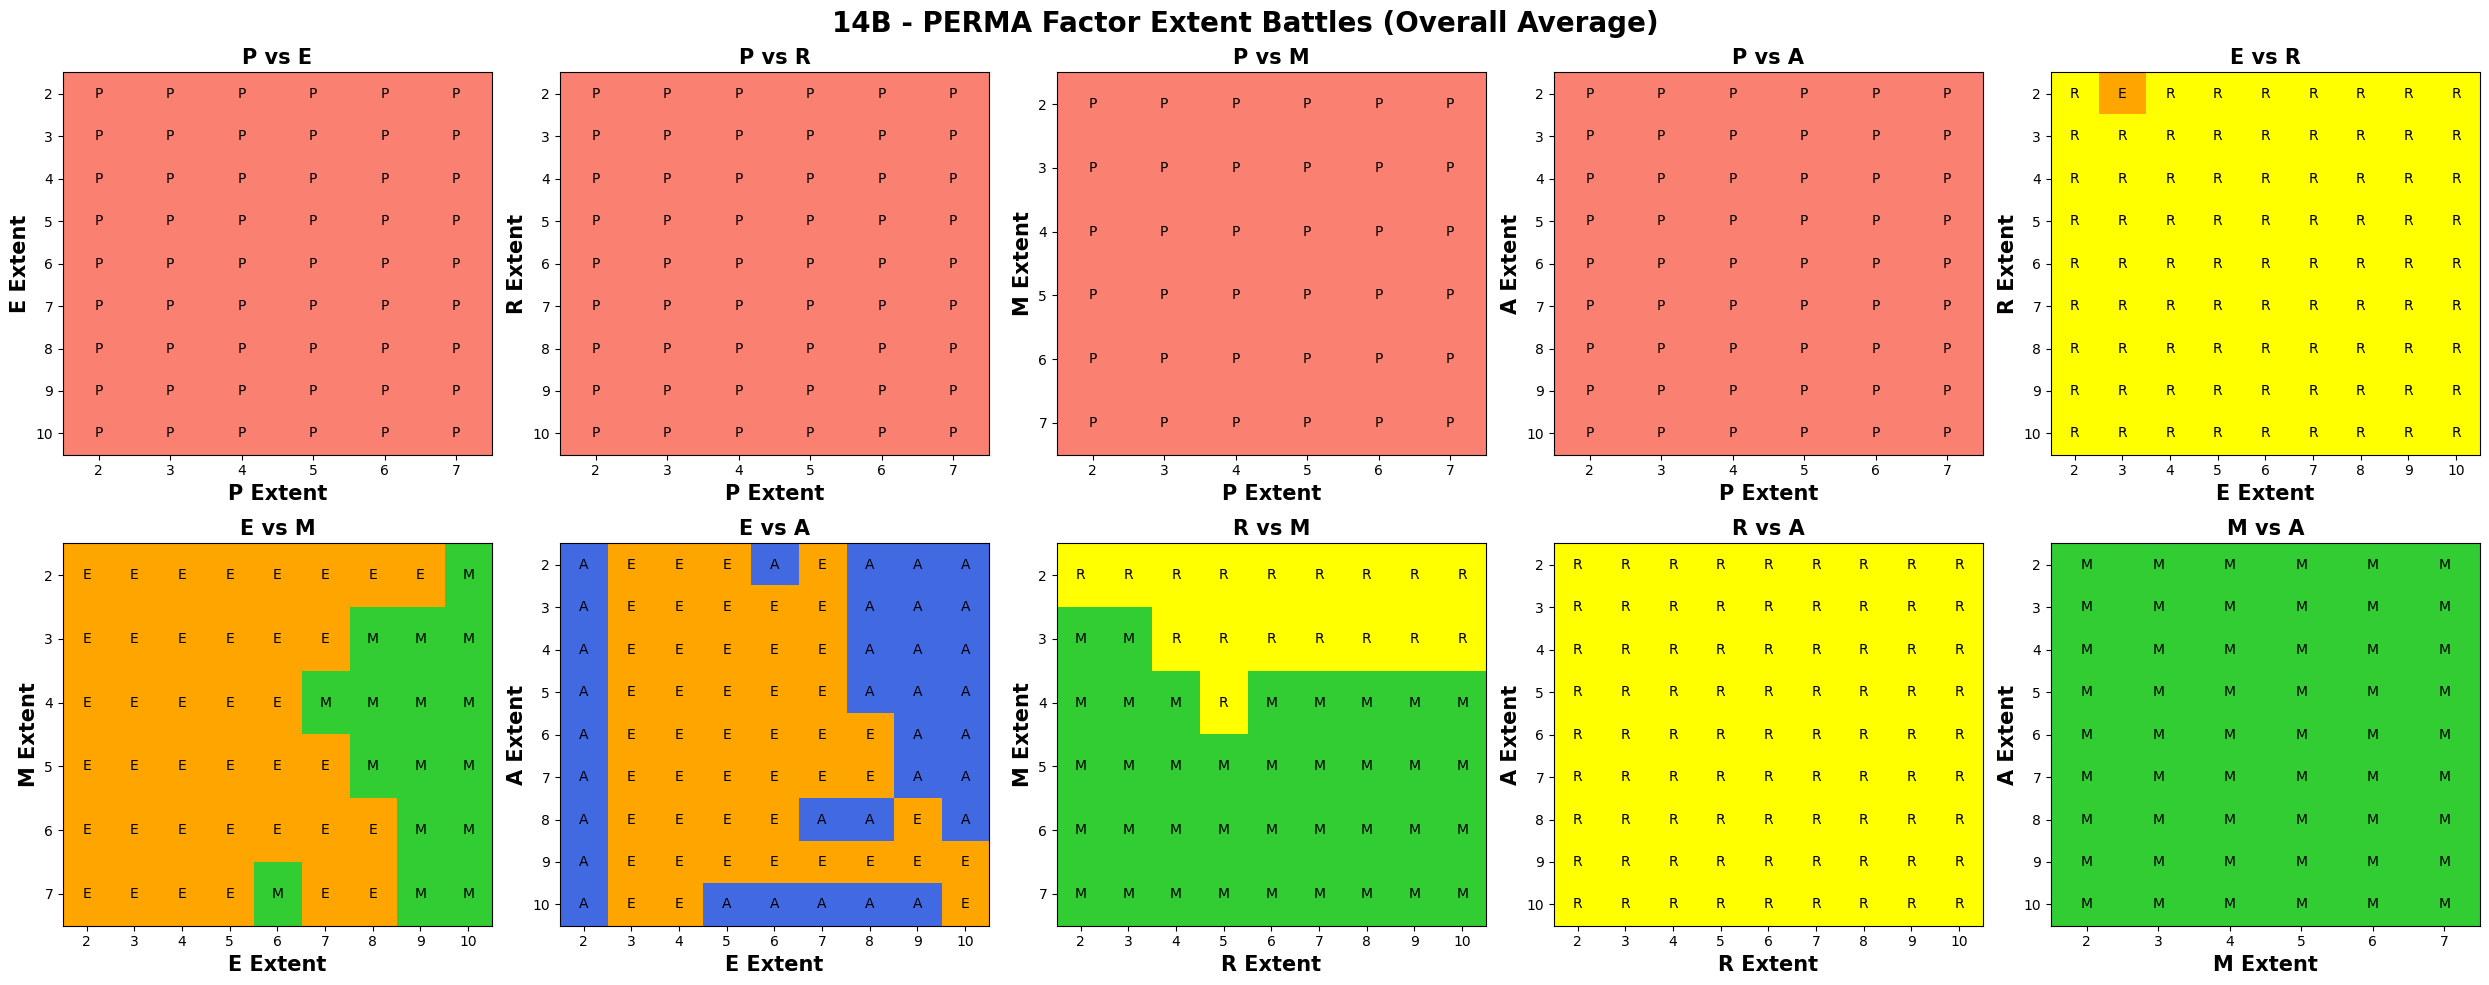

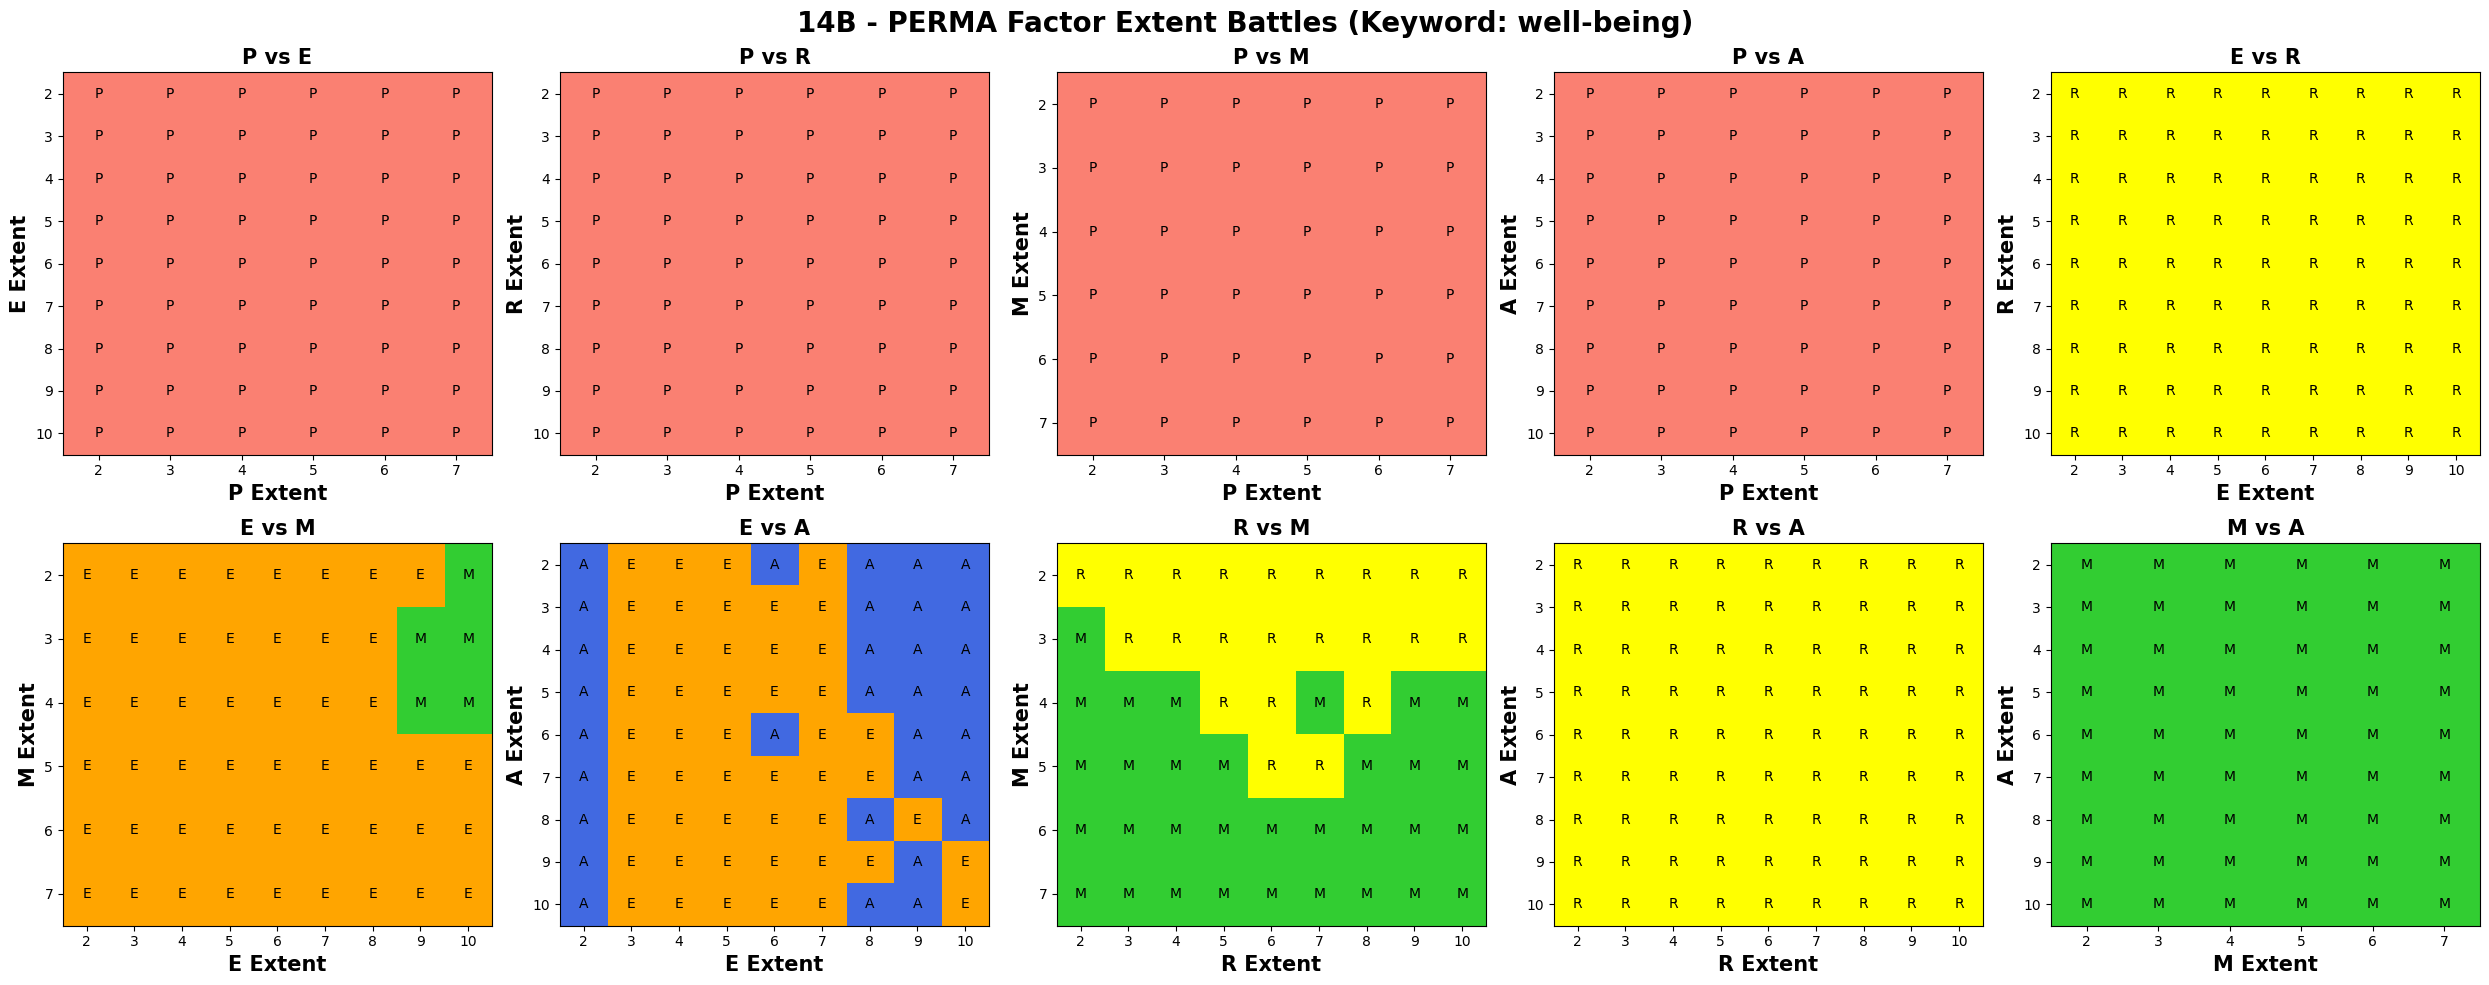

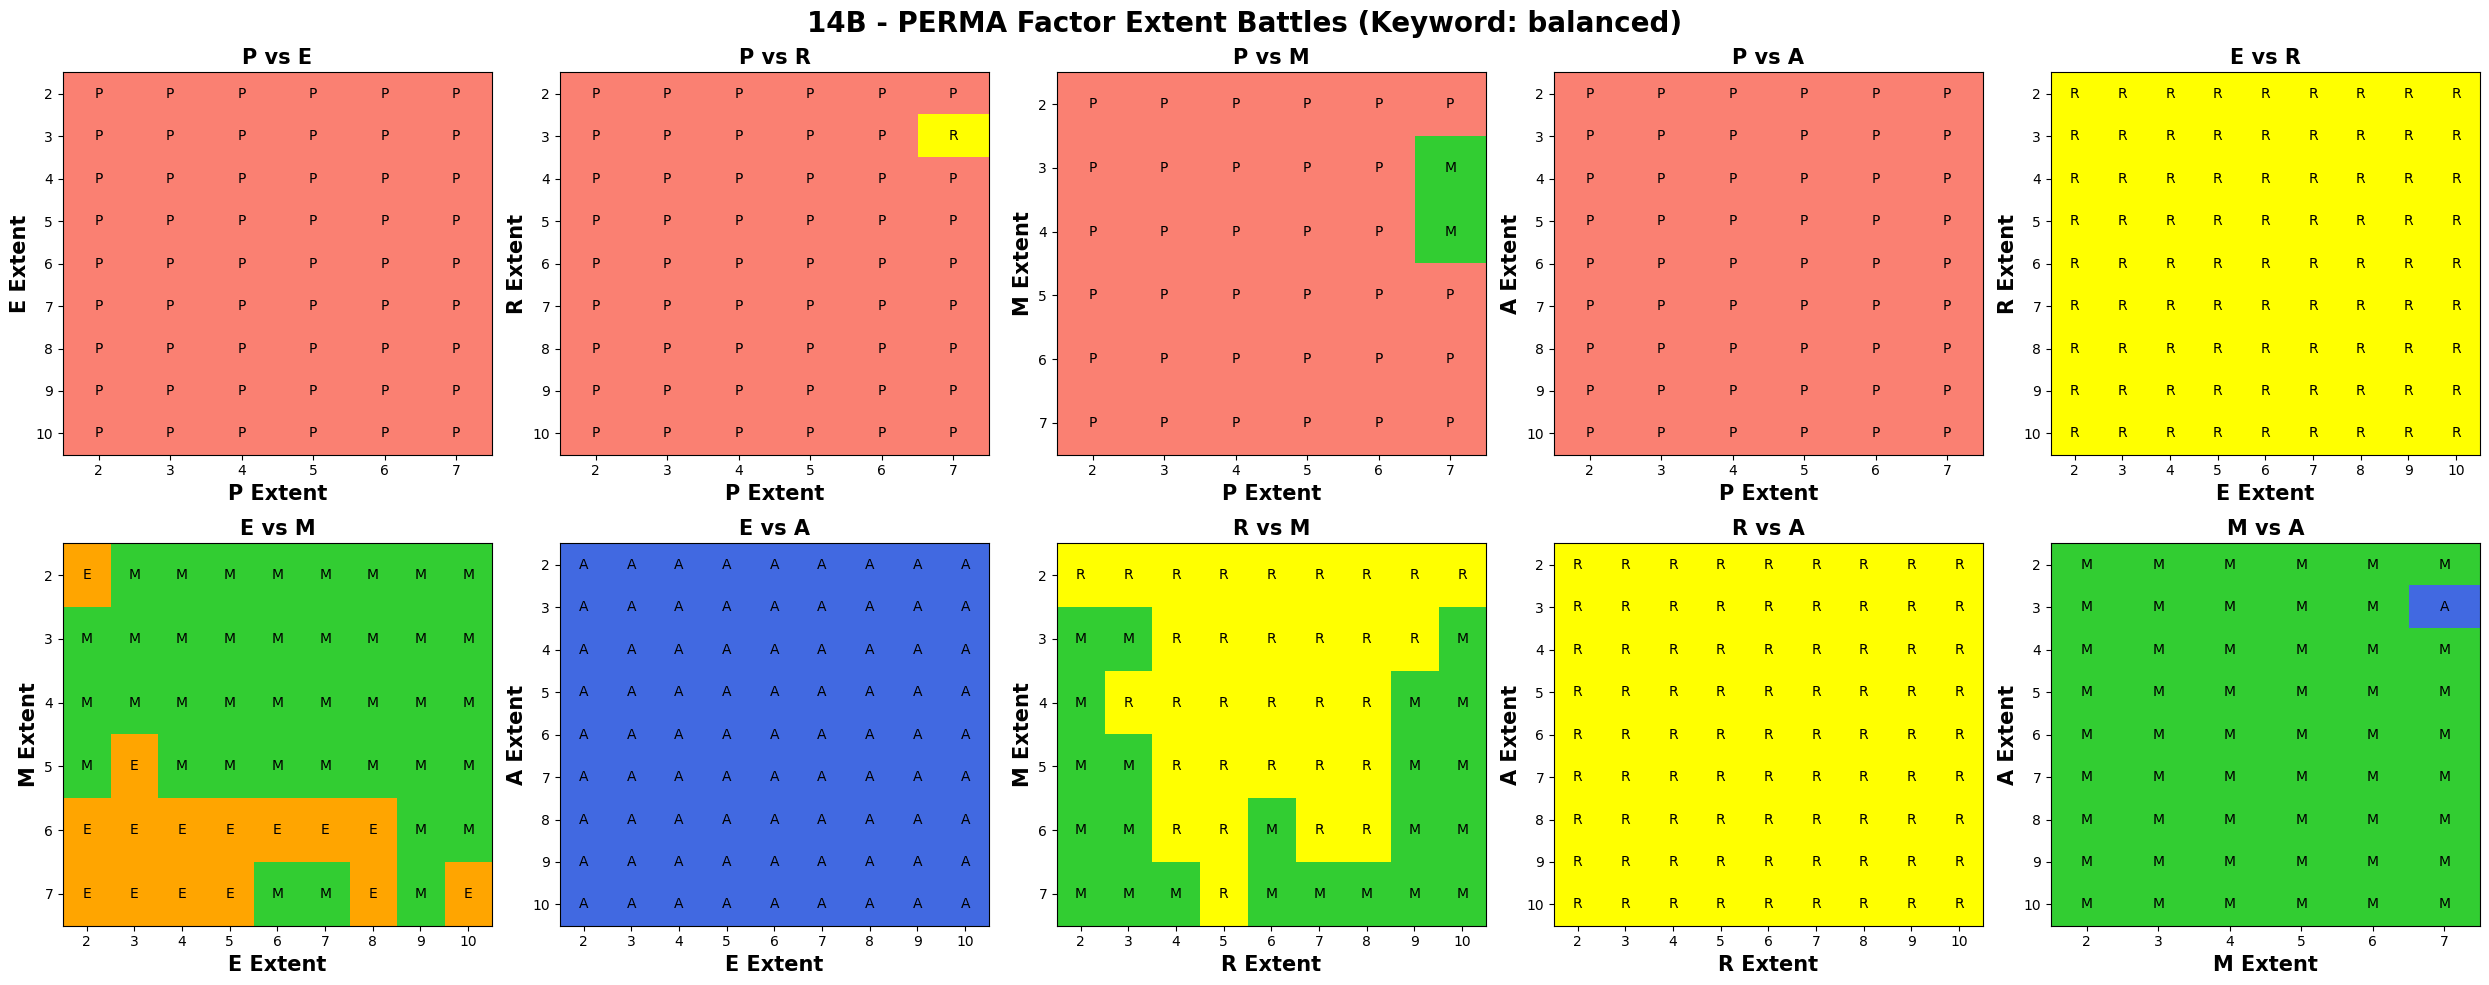

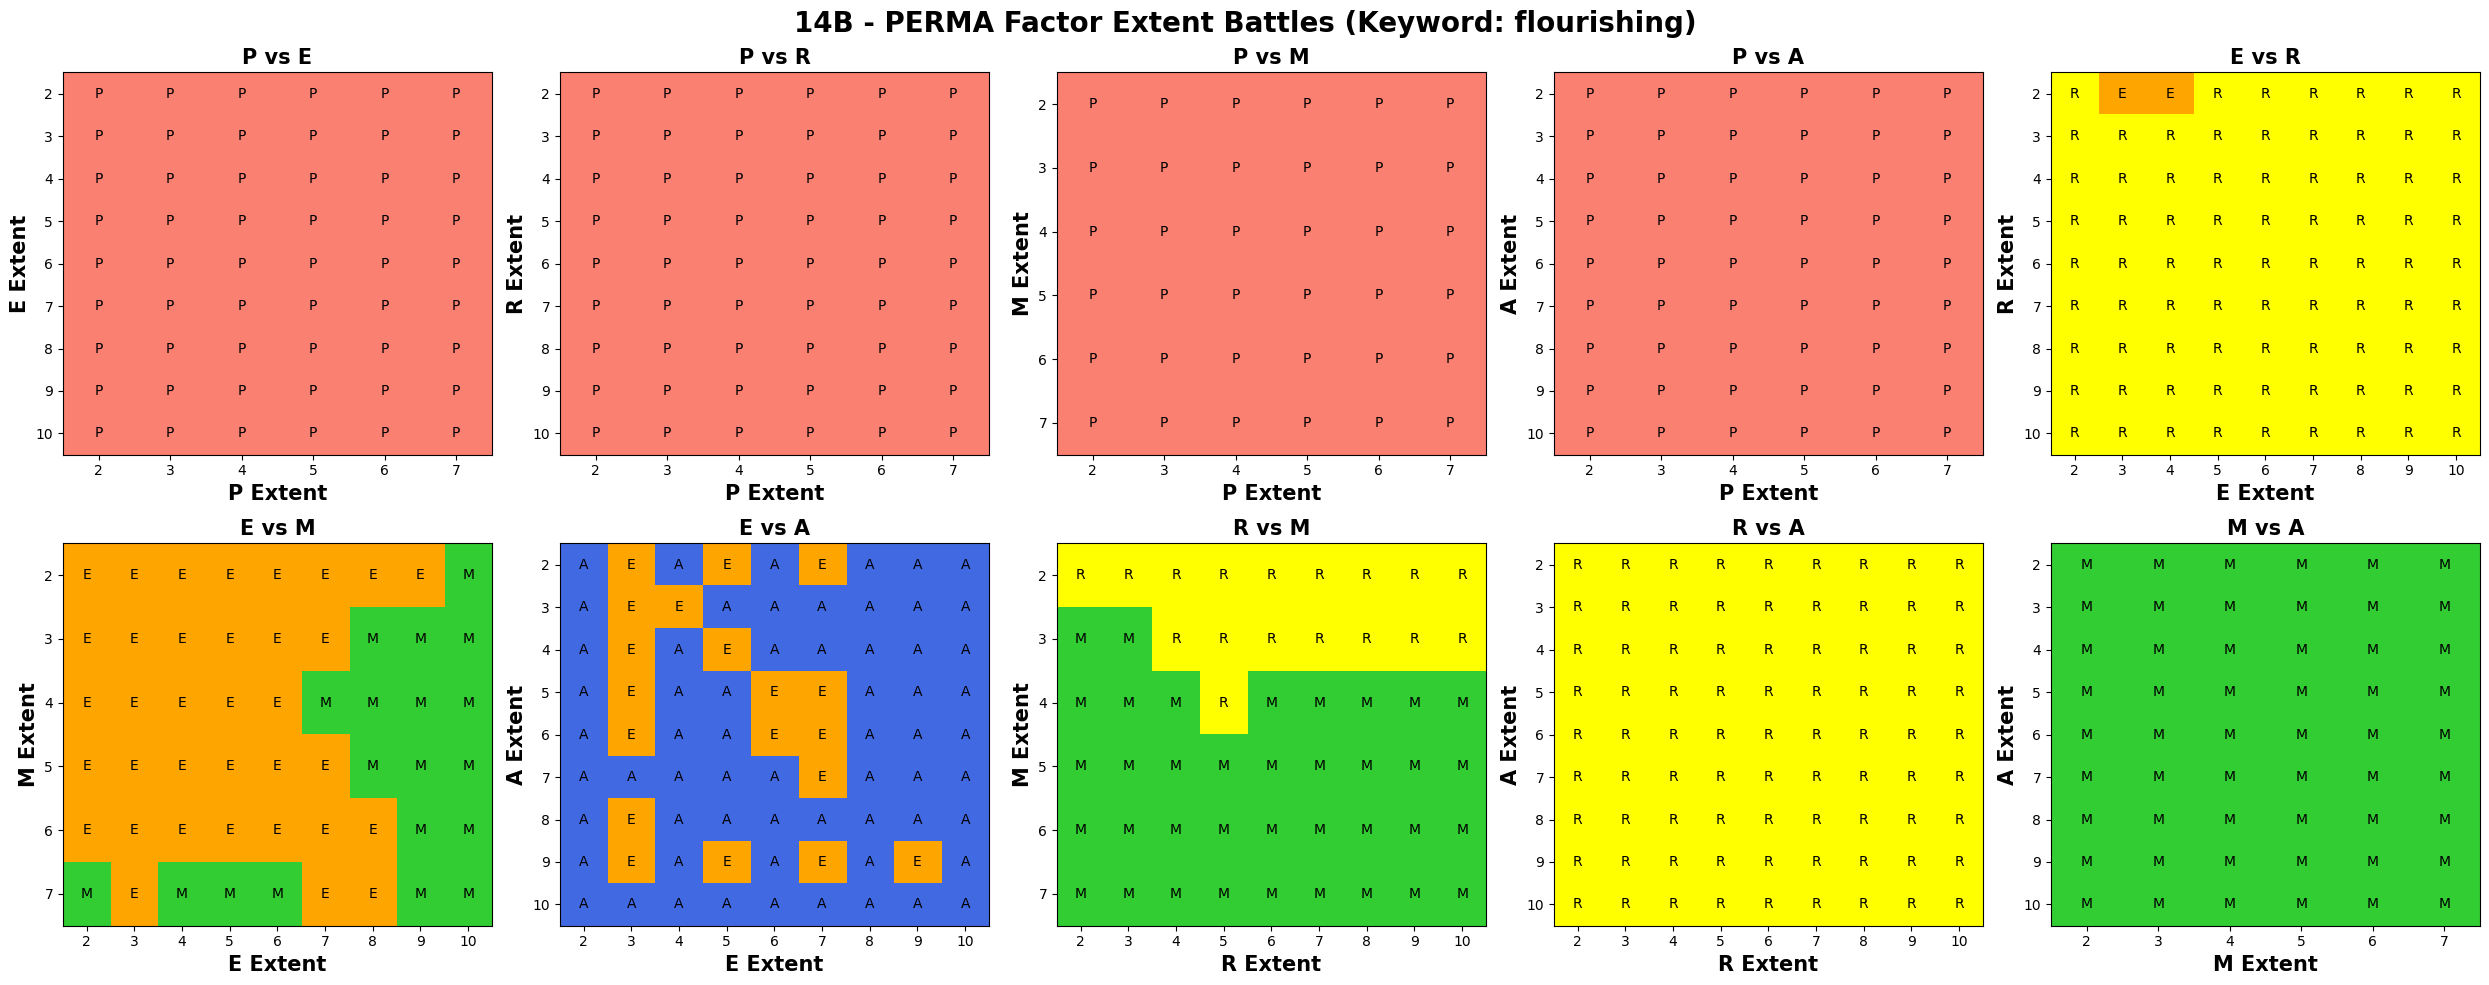

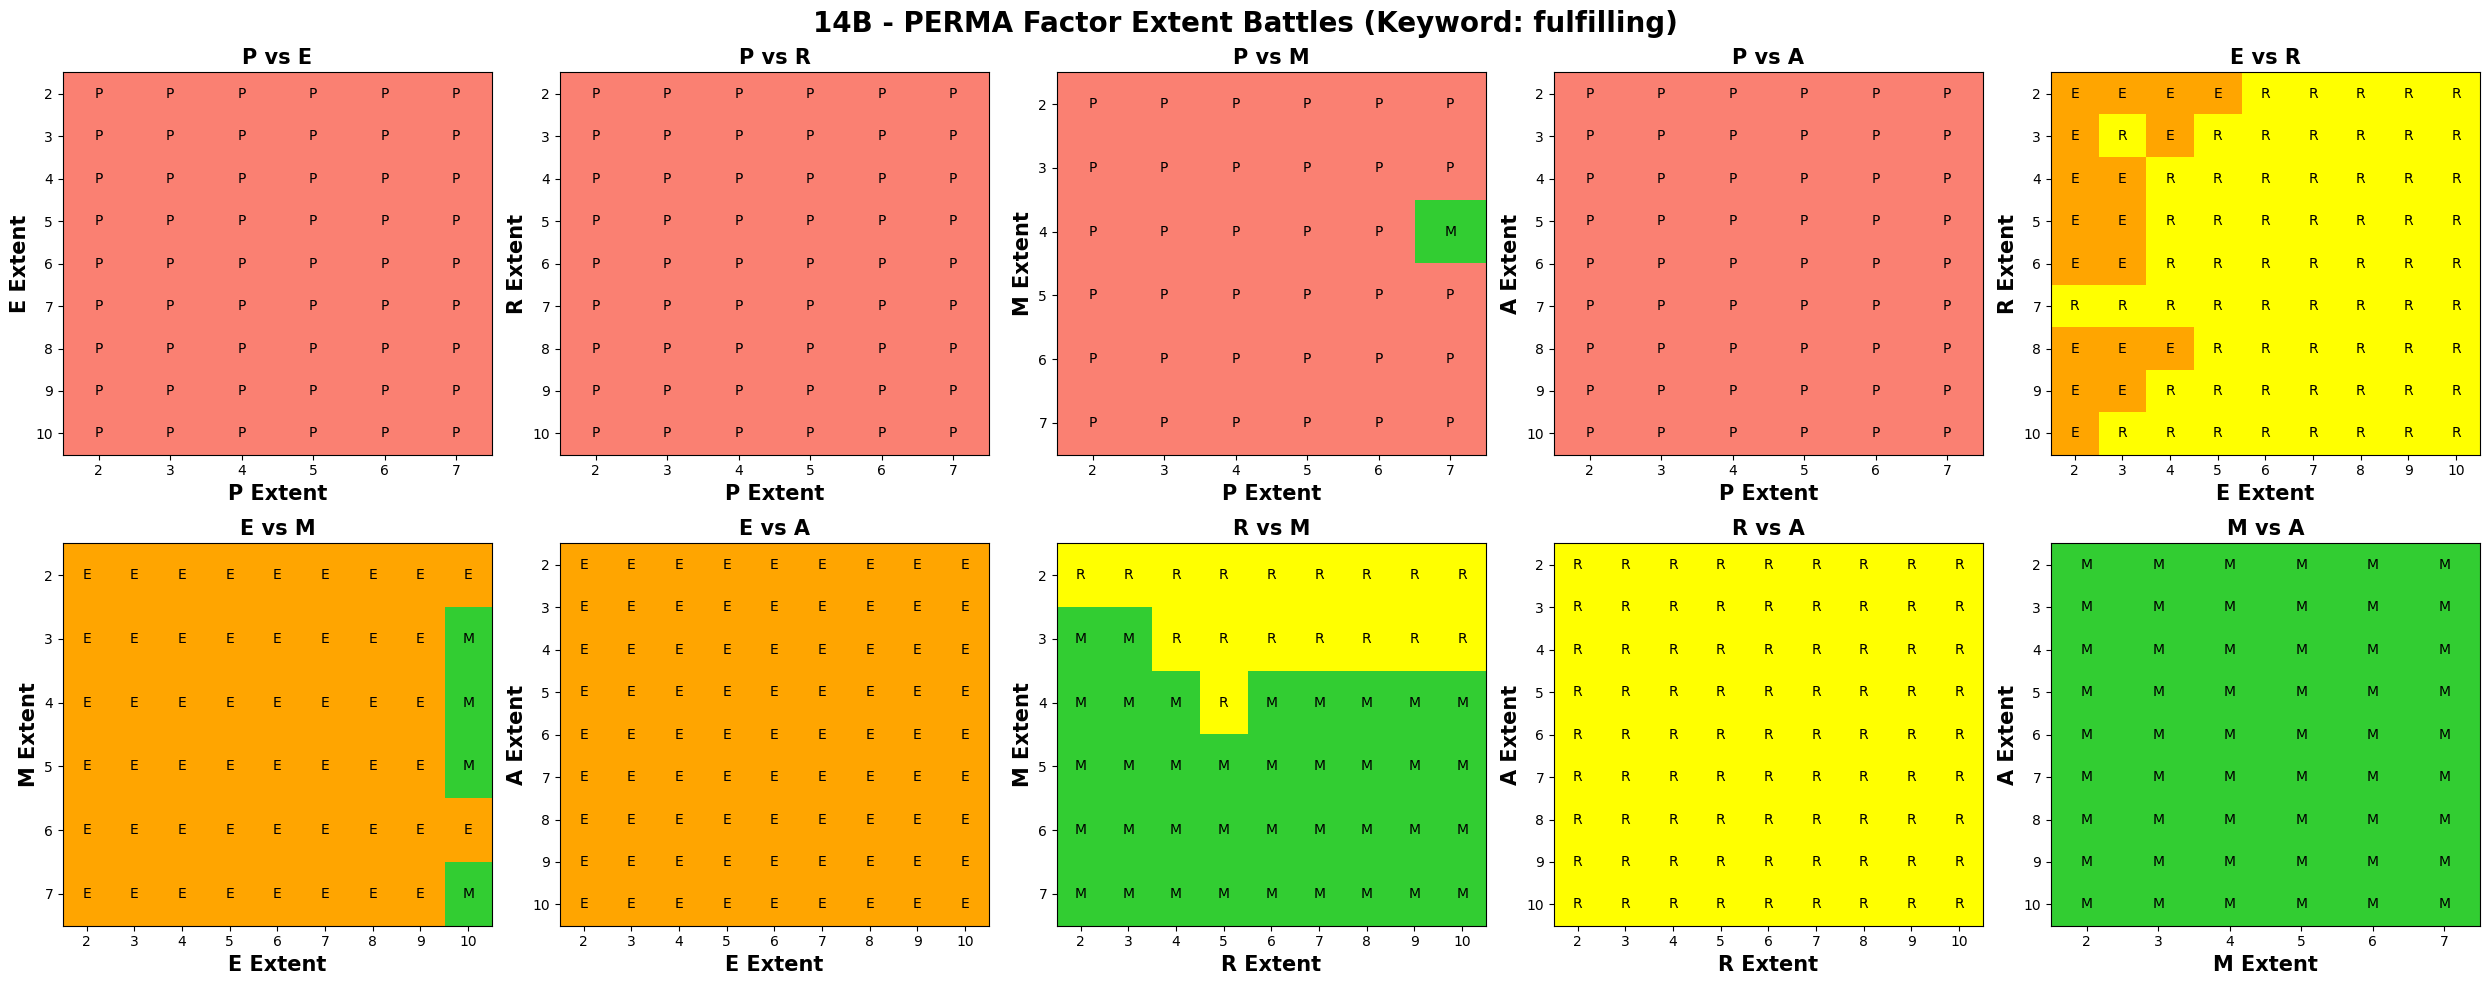

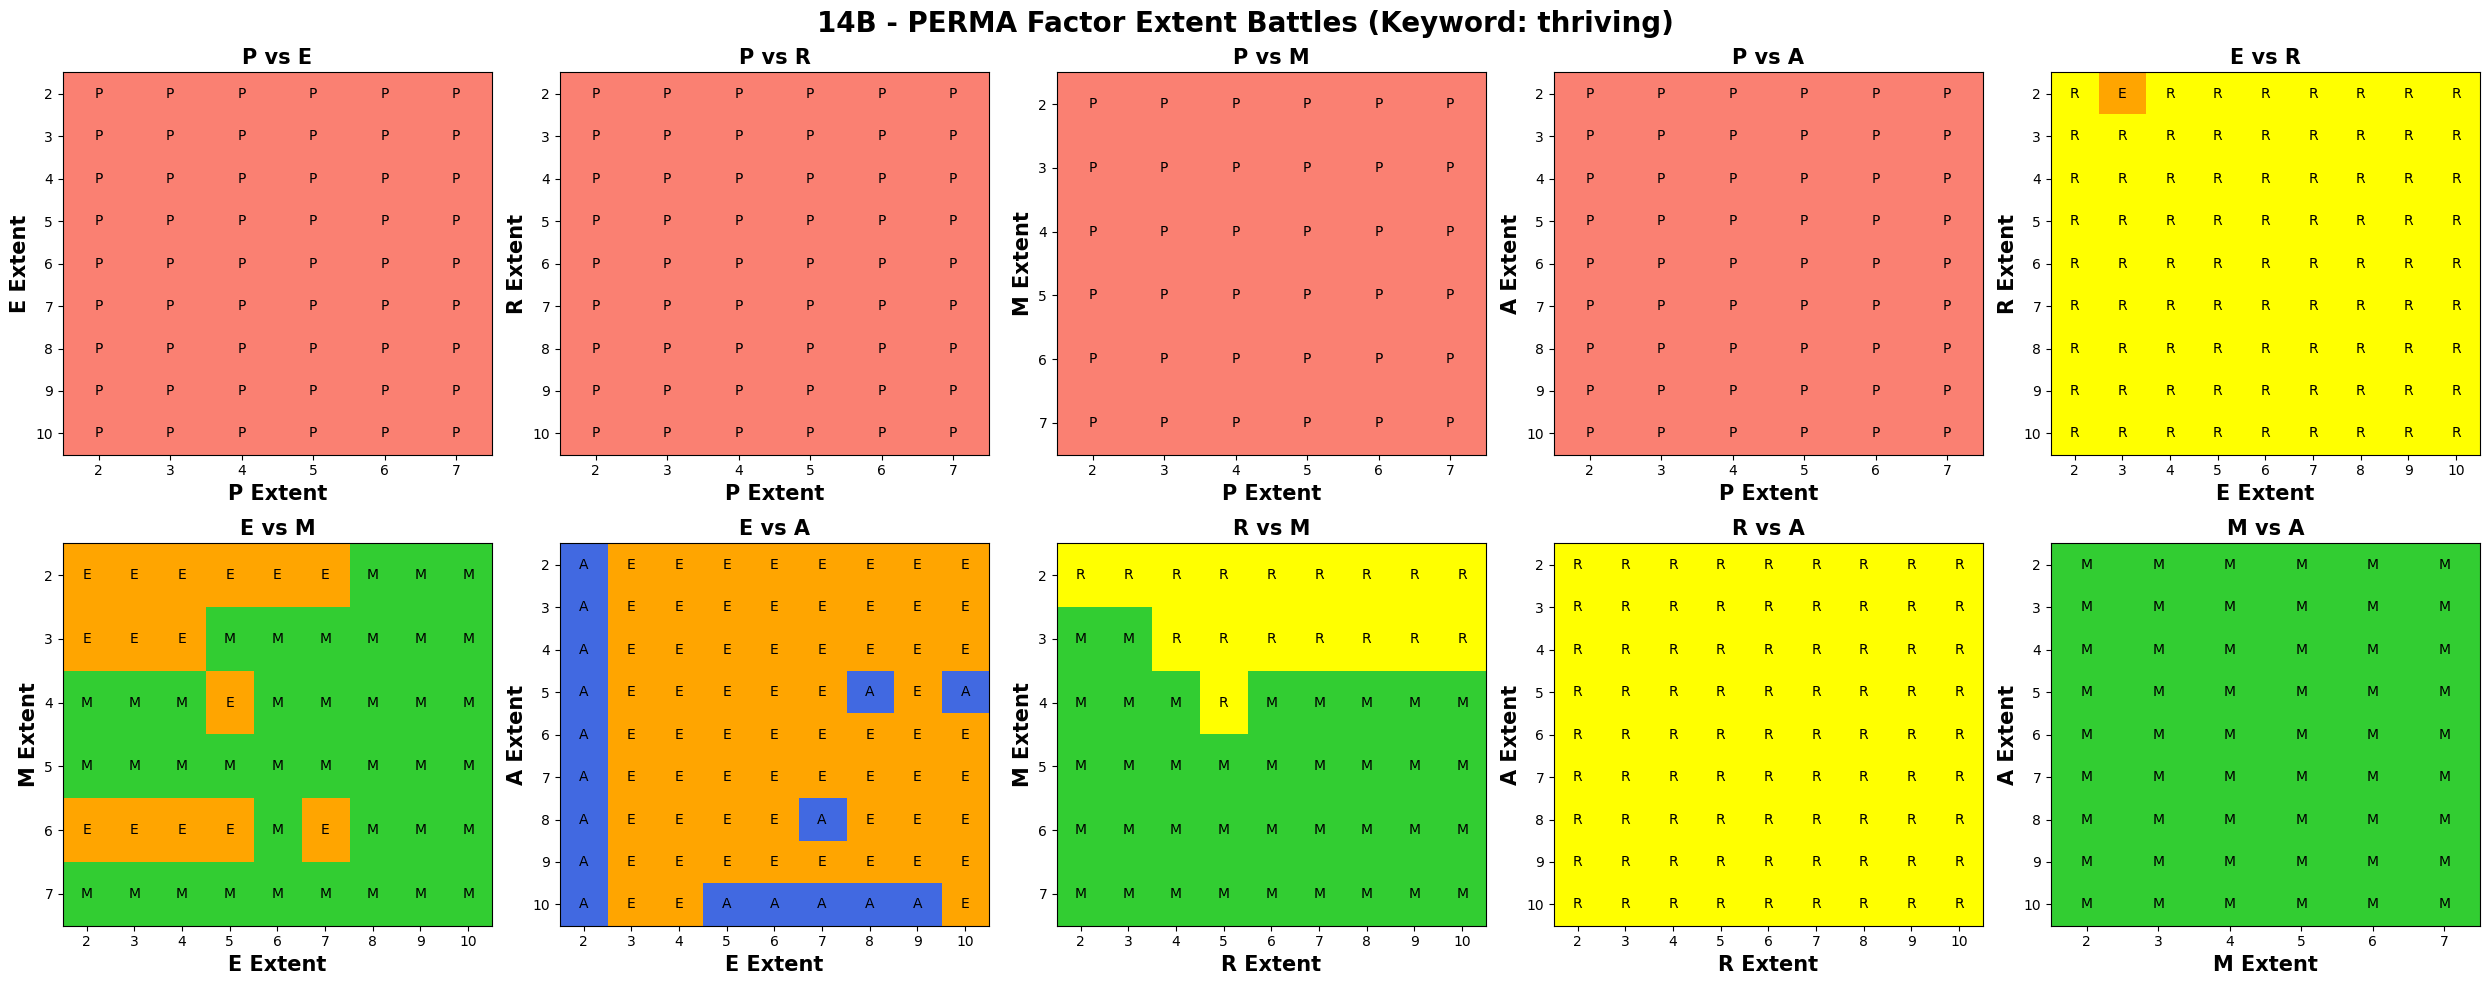


Analysis complete!

=== Processing 32b ===
PERMA combinations: [('P', 'E'), ('P', 'R'), ('P', 'M'), ('P', 'A'), ('E', 'R'), ('E', 'M'), ('E', 'A'), ('R', 'M'), ('R', 'A'), ('M', 'A')]
P vs E: 270 rows
  Factor1 (P) range: (2, 7)
  Factor2 (E) range: (2, 10)
  P: 270, E: 0
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
P vs R: 270 rows
  Factor1 (P) range: (2, 7)
  Factor2 (R) range: (2, 10)
  P: 224, R: 46
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
P vs M: 180 rows
  Factor1 (P) range: (2, 7)
  Factor2 (M) range: (2, 7)
  P: 161, M: 19
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
P vs A: 270 rows
  Factor1 (P) range: (2, 7)
  Factor2 (A) range: (2, 10)
  P: 270, A: 0
  Keywords found: ['well-being', 'balanced', 'flourishing', 'fulfilling', 'thriving']
E vs R: 405 rows
  Factor1 (E) range: (2, 10)
  Factor2 (R) range: (2, 10)
  E: 52, R: 353
  Keywords found: ['wel

In [ ]:
def analyze_perma_extent_battles(combined_df):
    """PERMA 조합별로 extent 기반 전투를 분석합니다."""
    # PERMA 요소들
    perma_factors = ['P', 'E', 'R', 'M', 'A']
    
    # 모든 가능한 PERMA 조합 생성
    perma_combinations = []
    for i in range(len(perma_factors)):
        for j in range(i + 1, len(perma_factors)):
            perma_combinations.append((perma_factors[i], perma_factors[j]))
    
    print(f"PERMA combinations: {perma_combinations}")
    
    # 각 조합별로 분석
    all_battle_results = {}
    
    for factor1, factor2 in perma_combinations:
        # 해당 조합의 reddit-com 데이터 필터링
        battle_data = combined_df[combined_df["question_id"] == "reddit-com"].copy()
        
        # reddit_type에서 해당 조합 찾기 (예: 'p-e', 'e-r' 등)
        factor1_lower = factor1.lower()
        factor2_lower = factor2.lower()
        
        # reddit_type 패턴 매칭
        reddit_patterns = [
            f"{factor1_lower}-{factor2_lower}",
            f"{factor2_lower}-{factor1_lower}"
        ]
        
        filtered_data = battle_data[battle_data["reddit_type"].isin(reddit_patterns)]
        
        print(f"{factor1} vs {factor2}: {len(filtered_data)} rows")
        
        if len(filtered_data) == 0:
            continue
        
        # extent 범위 파악
        factor1_extents = []
        factor2_extents = []
        
        for _, row in filtered_data.iterrows():
            op1_pos_num = extract_numbers_from_description(row.get("op1_pos", ""))
            op2_pos_num = extract_numbers_from_description(row.get("op2_pos", ""))
            
            if op1_pos_num is not None:
                factor1_extents.append(op1_pos_num)
            if op2_pos_num is not None:
                factor2_extents.append(op2_pos_num)
        
        if not factor1_extents or not factor2_extents:
            print(f"  No valid extent data found")
            continue
        
        factor1_range = (min(factor1_extents), max(factor1_extents))
        factor2_range = (min(factor2_extents), max(factor2_extents))
        
        print(f"  Factor1 ({factor1}) range: {factor1_range}")
        print(f"  Factor2 ({factor2}) range: {factor2_range}")
        
        # keyword별로 데이터 분리 (keyword는 op1_pos에서 추출)
        keyword_results = {}
        
        for _, row in filtered_data.iterrows():
            op1_pos_num = extract_numbers_from_description(row.get("op1_pos", ""))
            op2_pos_num = extract_numbers_from_description(row.get("op2_pos", ""))
            llm_choice = row.get('llm_choice')
            
            if pd.isna(llm_choice) or op1_pos_num is None or op2_pos_num is None:
                continue
            
            # keyword 필드 직접 사용
            keyword = row.get("keyword", "unknown")
            if not keyword or keyword == "unknown":
                # keyword가 없으면 op1_pos에서 숫자 제외한 부분 사용
                op1_pos_text = str(row.get("op1_pos", ""))
                keyword = re.sub(r'\d+', '', op1_pos_text).strip()
                if not keyword:
                    keyword = "unknown"
            
            # extent 조합을 키로 사용
            key = (op1_pos_num, op2_pos_num)
            
            if keyword not in keyword_results:
                keyword_results[keyword] = defaultdict(lambda: {'factor1_wins': 0, 'factor2_wins': 0})
            
            if llm_choice == 1:
                keyword_results[keyword][key]['factor1_wins'] += 1
            elif llm_choice == 2:
                keyword_results[keyword][key]['factor2_wins'] += 1
        
        # 전체 평균 결과 계산
        overall_results = defaultdict(lambda: {'factor1_wins': 0, 'factor2_wins': 0})
        for keyword_data in keyword_results.values():
            for key, data in keyword_data.items():
                overall_results[key]['factor1_wins'] += data['factor1_wins']
                overall_results[key]['factor2_wins'] += data['factor2_wins']
        
        all_battle_results[(factor1, factor2)] = {
            'keyword_results': keyword_results,
            'overall_results': overall_results,
            'factor1_range': factor1_range,
            'factor2_range': factor2_range
        }
        
        # 결과 요약 출력
        total_factor1_wins = sum(data['factor1_wins'] for data in overall_results.values())
        total_factor2_wins = sum(data['factor2_wins'] for data in overall_results.values())
        print(f"  {factor1}: {total_factor1_wins}, {factor2}: {total_factor2_wins}")
        print(f"  Keywords found: {list(keyword_results.keys())}")
    
    return all_battle_results

def create_perma_extent_plot(battle_results, model_name, plot_type="overall"):
    """PERMA 조합별 extent 기반 전투 결과를 10개 subplot으로 표시합니다."""
    # PERMA 요소별 고유 색상 정의
    perma_colors = {
        'P': '#FA8072',  # salmon (붉은색)
        'E': '#FFA500',  # orange (주황색) 
        'R': '#FFFF00',  # yellow (노란색)
        'M': '#32CD32',  # lime green (초록색)
        'A': '#4169E1'   # royal blue (파란색)
    }
    
    # PERMA 요소들
    perma_factors = ['P', 'E', 'R', 'M', 'A']
    
    # 모든 가능한 PERMA 조합 생성
    perma_combinations = []
    for i in range(len(perma_factors)):
        for j in range(i + 1, len(perma_factors)):
            perma_combinations.append((perma_factors[i], perma_factors[j]))
    
    # 10개의 subplot 생성 (2x5)
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    axes = axes.flatten()
    
    plot_title = "Overall Average" if plot_type == "overall" else f"Keyword: {plot_type}"
    fig.suptitle(f'{model_name} - PERMA Factor Extent Battles ({plot_title})', fontsize=20, fontweight='bold')
    
    for idx, (factor1, factor2) in enumerate(perma_combinations):
        if idx >= 10:
            break
            
        ax = axes[idx]
        
        if (factor1, factor2) in battle_results:
            result = battle_results[(factor1, factor2)]
            factor1_range = result['factor1_range']
            factor2_range = result['factor2_range']
            
            if plot_type == "overall":
                battle_data = result['overall_results']
            else:
                battle_data = result['keyword_results'].get(plot_type, {})
            
            factor1_values = list(range(factor1_range[0], factor1_range[1] + 1))
            factor2_values = list(range(factor2_range[0], factor2_range[1] + 1))
            
            heatmap_data = np.zeros((len(factor2_values), len(factor1_values)))
            
            for i, factor2_val in enumerate(factor2_values):
                for j, factor1_val in enumerate(factor1_values):
                    key = (factor1_val, factor2_val)
                    if key in battle_data:
                        factor1_wins = battle_data[key]['factor1_wins']
                        factor2_wins = battle_data[key]['factor2_wins']
                        
                        if factor1_wins > factor2_wins:
                            heatmap_data[i, j] = 1  # factor1 선택
                        elif factor2_wins > factor1_wins:
                            heatmap_data[i, j] = 2  # factor2 선택
            
            colors = ['white', perma_colors[factor1], perma_colors[factor2]]
            cmap = plt.cm.colors.ListedColormap(colors)
            im = ax.imshow(heatmap_data, cmap=cmap, aspect='auto', vmin=0, vmax=2)
            ax.set_xlabel(f'{factor1} Extent', fontsize=15)
            ax.set_ylabel(f'{factor2} Extent', fontsize=15)
            ax.set_title(f'{factor1} vs {factor2}', fontsize=15, fontweight='bold')
            ax.set_xticks(range(len(factor1_values)))
            ax.set_yticks(range(len(factor2_values)))
            ax.set_xticklabels(factor1_values)
            ax.set_yticklabels(factor2_values)
            
            for i in range(len(factor2_values)):
                for j in range(len(factor1_values)):
                    if heatmap_data[i, j] == 1:
                        ax.text(j, i, factor1, ha="center", va="center", 
                               color="black", fontsize=10)
                    elif heatmap_data[i, j] == 2:
                        ax.text(j, i, factor2, ha="center", va="center", 
                               color="black", fontsize=10)
                        
        else:
            ax.set_title(f'{factor1} vs {factor2}')
            ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=15)
    
    for idx in range(len(perma_combinations), 10):
        if idx < len(axes):
            axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig

models = ['7b', '14b', '32b']
    
for model in models:
    print(f"\n=== Processing {model} ===")
        
    df, reversed_df, combined_df = load_model_data(model)            
    battle_results = analyze_perma_extent_battles(df)
            
    if battle_results:
        fig = create_perma_extent_plot(battle_results, model.upper(), "overall")
        plt.show()

        first_key = list(battle_results.keys())[0]
        keywords = list(battle_results[first_key]['keyword_results'].keys())
                    
        for keyword in keywords:
            fig = create_perma_extent_plot(battle_results, model.upper(), keyword)
            plt.show()
    
    else:
        print(f"No PERMA extent battle data found")
                
    
    print("\nAnalysis complete!")


